# basic set up

In [1]:
#basic set up
%matplotlib inline
import logging
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import os
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from IPython.display import clear_output
from matplotlib.path import Path
import pandas as pd
import pdb
from logzero import logger
from utils.common_imports import *

logging.getLogger('matplotlib').setLevel(logging.WARNING)


#netflow 
import ets_fiber_assigner.netflow as nf
import ets_fiber_assigner.io_helpers as io_helpers
from ics.cobraOps.Bench import Bench
from ics.cobraOps.TargetGroup import TargetGroup
from ics.cobraOps.CobrasCalibrationProduct import CobrasCalibrationProduct
from ics.cobraOps.BlackDotsCalibrationProduct import BlackDotsCalibrationProduct
from pfs.utils.fiberids import FiberIds

from ics.cobraCharmer.pfiDesign import PFIDesign
from ics.cobraCharmer.cobraCoach.cobraCoach import CobraCoach
from ics.cobraOps.DistanceTargetSelector import DistanceTargetSelector

from ics.cobraOps.CollisionSimulator2 import CollisionSimulator2
from ics.cobraOps.CollisionSimulator import CollisionSimulator
from ics.cobraOps.cobraConstants import NULL_TARGET_POSITION, NULL_TARGET_ID
from ics.cobraOps import plotUtils
from collections import defaultdict

# key functions

In [2]:
# read the pointing centers from the file
def read_pointings(file):
    """
    Read pre-defined pointings from a file
    """
    try:
        # first try reading as ecsv format
        t = Table.read(file, format="ascii.ecsv")
        return t["R.A."], t['Dec.']
    except:
        pass

    with open(file) as f:
        ras = []
        decs = []
        ll = f.readlines()
        for l in ll[1:]:
            if not l.startswith("#"):
                tt = l.split()
                ra, dec = (float(tt[0]), float(tt[1]))
                ras.append(ra)
                decs.append(dec)
    return np.array(ras), np.array(decs)

# TODO: try a more efficient way to contruct the target list, add alreadyObserved to the target list either in netflow Targets or in this function
def construct_tgt_list(catalog_path = "../proc_data/", \
                       fn_list = ["cos_select.ecsv", "star_select.ecsv", "sky_select.ecsv"], \
                       prefix_list = ["sci", "cal", "sky"], calibration_list = [False, True, True]):
    '''
    Construct target list
    '''
    print("construct target list:")
    for i, fn_i in enumerate(fn_list):
        fn = catalog_path + fn_i
        print(fn)
        
        # read all targets into a single list, giving them their proper types
        if(i<1):
            if(not calibration_list[i]): tgt = nf.readScientificFromFile(fn, prefix_list[i])
            if(calibration_list[i]): tgt = nf.readCalibrationFromFile(fn, prefix_list[i])
        else:
            if(not calibration_list[i]): tgt += nf.readScientificFromFile(fn, prefix_list[i])
            if(calibration_list[i]): tgt += nf.readCalibrationFromFile(fn, prefix_list[i])

    print("In total, there are %d targets." % len(tgt))

    # sample of sci targets
    sample_sci = []
    for t in tgt:
        if(t.targetclass[:3] == 'sci'): sample_sci.append([t.ID,t.ra,t.dec])  

    sample_sci = np.array(sample_sci)
    
    return tgt, sample_sci

# TODO: play with the cost value for different classes
def def_classdict():
    '''define classdict for netflow run
    
    Parameters
    ==========
    None
    
    Returns
    =======
    classdict
    '''
    # create the dictionary containing the costs and constraints for all classes
    # of targets
    classdict = {}
    classdict["sci_P1"] = {"nonObservationCost": 400,
                           "partialObservationCost": 1e6, "calib": False}
    classdict["sci_P2"] = {"nonObservationCost": 200,
                           "partialObservationCost": 1e6, "calib": False}
    classdict["sci_P3"] = {"nonObservationCost": 100,
                           "partialObservationCost": 1e6, "calib": False}
    
    #for ancillary targets
    classdict["anc_P1"] = {"nonObservationCost": 50,
                           "partialObservationCost": 1e6, "calib": False}
    classdict["anc_P2"] = {"nonObservationCost": 10,
                           "partialObservationCost": 1e6, "calib": False}

    #need to ask PFS project office to get the "numRequired"
    classdict["sky"] = {"numRequired": 400,
                        "nonObservationCost": 1e6, "calib": True}
    #100-200 stars - Masayuki
    classdict["cal"] = {"numRequired": 200,
                        "nonObservationCost": 1e6, "calib": True}

    return classdict



def write_output(tgt, res, tpos, telescopes, fdir_out, fn_out, t_obs=900):
    '''write the output of fiber assignment
    Parameters
    ==========
    fdir_out: string
        output folder directory
    fn_out: string
        output file name
    '''
    
    with open(fdir_out + fn_out, "w") as f:
        for i, (vis, tp, tel) in enumerate(zip(res, tpos, telescopes)):
            print("exposure {}:".format(i))
            print("  assigned Cobras: {}".format(len(vis)))
            tdict = defaultdict(int)
            f.write("# Exposure {}: duration {}s, RA: {}, Dec: {}, PA: {}\n".
                    format(i+1, t_obs, tel._ra, tel._dec, tel._posang))
            f.write("# Target    Fiber          X          Y         "
                    "RA        DEC\n")
            for tidx, cidx in vis.items():
                tdict[tgt[tidx].targetclass] += 1 #tgt[].targetclass = 'sci_Px'
                f.write("{:} {:6d} {:10.5f} {:10.5f} {:10.5f} {:10.5f}\n"
                        .format(tgt[tidx].ID, cidx+1, tp[tidx].real, tp[tidx].imag,
                                tgt[tidx].ra, tgt[tidx].dec))
            for cls, num in tdict.items():
                print("   {}: {}".format(cls, num))
                
                
def cal_completeness(tgt, res, tpos, telescopes, Plot=False, fn_fig='', Save=False, fn_fibeff=''):
    '''calculate the completeness of the targets and fiber assignment fraction
    Parameters
    ==========
    fdir_out: string
        output folder directory
    Plot: boolean
        plot the results if True 
    '''
    
    #fiber assignment fraction of each pointing
    fib_eff = [] 
    #fiber assignment fraction of pointing which observed galaxies
    fib_eff_gal = []
    fib_eff_anc = []
    #calibration targets
    fib_eff_star = []
    fib_eff_sky = []

    #objects that got allocated a fiber
    obj_allo = []
    for i, (vis, tp, tel) in enumerate(zip(res, tpos, telescopes)):
        fib_eff_t = len(vis)/2394.*100 #2394 fibers available
        fib_eff.append(fib_eff_t)

        n_fib_gal = 0
        n_fib_anc = 0
        n_fib_star = 0
        n_fib_sky = 0
        #tidx is the id in tgt list; cidx is the fiber id, starting from 0
        for tidx, cidx in vis.items():
            obj_allo.append(["Point_"+str(i+1), tel._ra, tel._dec, tel._posang, tgt[tidx].ID,
                            cidx+1, tp[tidx].real, tgt[tidx].ra, tgt[tidx].dec,
                            tgt[tidx].targetclass])

            if tgt[tidx].targetclass[:3]=='sci': n_fib_gal+=1
            if tgt[tidx].targetclass[:3]=='anc': n_fib_anc+=1
            if tgt[tidx].targetclass[:3]=='sky': n_fib_sky+=1
            if tgt[tidx].targetclass[:3]=='cal': n_fib_star+=1

        fib_eff_gal.append(n_fib_gal/2394.*100)
        fib_eff_anc.append(n_fib_anc/2394.*100)
        fib_eff_star.append(n_fib_star/2394.*100)
        fib_eff_sky.append(n_fib_sky/2394.*100)

        print("exposure {}:".format(i))
        print("assigned Cobras(%): {:.2f}%; gal--{:.2f}%, anc--{:.2f}%, sky--{:.2f}%, star--{:.2f}%". format(fib_eff[i], fib_eff_gal[i], fib_eff_anc[i], fib_eff_sky[i], fib_eff_star[i]))
    
    if(Save==True):
        np.savetxt(fn_fibeff, np.c_[fib_eff, fib_eff_gal, fib_eff_anc, fib_eff_sky, fib_eff_star])
    
    #unique tgt_class
    tgt_class = []
    for tgt_i in tgt:
        tgt_class.append(tgt_i.targetclass)
    tgt_class = np.array(tgt_class)
    uniq_tgt_class = np.unique(tgt_class)

    #completeness fraction
    tgt_class_allo = np.array([obj_allo_i[-1] for obj_allo_i in obj_allo])
    comp_out = {}
    for ii, uniq_tgt_i in enumerate(uniq_tgt_class):
        mask_i = tgt_class == uniq_tgt_i
        tot = len(tgt_class[mask_i])

        mask_ii = tgt_class_allo == uniq_tgt_i
        done = len(tgt_class_allo[mask_ii])

        comp_out[uniq_tgt_i] = done/tot
        
    print("comp_out=", comp_out)
    
    #plot
    if(Plot==True):  
        npoint_used = len(tpos)
        msk_sci_class =  [uniq_tgt_class_i[:3]=='sci' for uniq_tgt_class_i in uniq_tgt_class]
        sci_class = uniq_tgt_class[msk_sci_class]
        msk_anc_class =  [uniq_tgt_class_i[:3]=='anc' for uniq_tgt_class_i in uniq_tgt_class]
        sci_class = np.append(sci_class, uniq_tgt_class[msk_anc_class])
        print(sci_class)
        
        plt.figure(figsize=(12, 4))
        plt.subplot(121)
        for ii, sci_class_ii in enumerate(sci_class):
            plt.bar([ii+1], comp_out[sci_class_ii], width=1., fc='tomato', ec='none', alpha=0.8, zorder=10)
            plt.bar([ii+1], comp_out[sci_class_ii], width=1., ec='tomato', fc='none', lw=1)

        plt.plot([0,10], [0.8,0.8], 'k--', lw=2, zorder=11)
        plt.xticks(np.arange(len(sci_class))+1, sci_class, fontsize=15)
        plt.ylabel('completeness fraction', fontsize=15)
        plt.xlim(0, len(sci_class)+2)
        plt.ylim(0, 1.)

        plt.subplot(122)
        plt.bar(np.arange(0,len(fib_eff_gal),1), fib_eff_gal, width=0.8, fc='tomato', ec='none', alpha=0.6, zorder=10)
        plt.bar(np.arange(0,len(fib_eff_anc),1), fib_eff_anc, width=0.8, fc='purple', ec='none', alpha=0.5)
        plt.bar(np.arange(0,len(fib_eff_sky),1), fib_eff_sky, width=0.8, fc='blue', ec='none', alpha=0.5)
        plt.bar(np.arange(0,len(fib_eff_star),1), fib_eff_star, width=0.8, fc='gray', ec='none', alpha=0.5)

        plt.plot([0,npoint_used+1.], [80,80], 'k--', lw=2, zorder=11)
        plt.plot([0,npoint_used+1.], [np.mean(fib_eff_gal), np.mean(fib_eff_gal)], '--', color='tomato', lw=2, zorder=11)
        plt.plot([0,npoint_used+1.], [np.mean(fib_eff_anc), np.mean(fib_eff_anc)], '--', color='purple', lw=2, zorder=11)
        plt.plot([0,npoint_used+1.], [np.mean(fib_eff_sky), np.mean(fib_eff_sky)], '--', color='blue', lw=2, zorder=11)
        plt.plot([0,npoint_used+1.], [np.mean(fib_eff_star), np.mean(fib_eff_star)], '--', color='gray', lw=2, zorder=11)

        plt.text(npoint_used*0.8, 100, "cosmology--{:2.2f}%".format(np.mean(fib_eff_gal)), color='tomato', fontsize=12)
        plt.text(npoint_used*0.8, 92, "ancillary--{:2.2f}%".format(np.mean(fib_eff_anc)), color='purple', fontsize=12)
        plt.text(npoint_used*0.8, 84, "sky--{:2.2f}%".format(np.mean(fib_eff_sky)), color='blue', fontsize=12)
        plt.text(npoint_used*0.8, 76, "star--{:2.2f}%".format(np.mean(fib_eff_star)), color='gray', fontsize=12)
        plt.xlim(0, npoint_used+1.)
        plt.ylim(0, 110.)
        plt.xlabel('Pointing', fontsize=15)
        plt.ylabel('fiber alloc fraction', fontsize=15)

        plt.savefig(fn_fig, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        
    return comp_out

    

## execute function

In [3]:
# (DONE)TODO-0: plot the distribution of the cosmology, star, and sky
# (DONE)TODO-1: make posang and otime as input parameters
# (DONE)TODO-2: test different otime outputs of tpos and netflow
# (DONE)TODO-3: make bench, Gurobi options as input parameters
# TODO-4: test different Gurobi options, vis_cost, cobraMoveCost
# TODO-5: check blackDotPenalty, collision_distance, and minSkyTargetsPerInstrumentRegion
# TODO-6: write code to get longer exposure in the 2nd visit for some targets
# TODO-7: test which part of the code is the bottleneck
def execute(peaks, tgt, classdict, alreadyObserved, t_obs = 900., two_stage = False, collision_sim_version = 2, tele_params={"otime":"2025-08-20T11:00:00Z", "posang":0.}, bench = None, cobracoach = None, gurobiOptions = None):
    # get a complete, idealized focal plane configuration
    if bench is None:
        Exception("bench is not defined")
    if cobracoach is None:
        Exception("cobracoach is not defined")
        
    # test_a 
    # otime = "2025-08-20T10:00:00Z"
    # test_b
    # otime = "2025-08-20T12:00:00Z"
    # test_c
    # otime = "2025-08-20T11:00:00Z"

    raTel, decTel = peaks[:, 0], peaks[:, 1]
    posang = tele_params["posang"]
    otime = tele_params["otime"]
    telescopes = []

    # number of distinct observations
    nvisit = len(raTel)

    # generate telescope pointings for every observation
    for ii in range(nvisit):
        telescopes.append(nf.Telescope(raTel[ii], decTel[ii], posang, otime))

    # get focal plane positions for all targets and all visits
    tpos = [tele.get_fp_positions(tgt) for tele in telescopes]
    
    # optional: slightly increase the cost for later observations,
    # to observe as early as possible
    # test_defualt 
    vis_cost = [0.1*i for i in range(nvisit)]
    # test_vis_cost -- no difference in the output
    # vis_cost = [0.*i for i in range(nvisit)]

    # optional: penalize assignments where the cobra has to move far out
    def cobraMoveCost(dist):
        # test_default
        return 0.01*dist 
        # test_cobraMoveCost, fiber efficency is slightly lower (75.40 versus 75.44) in one of the two pointings 
        # return 0.0001*dist
    
    # test_default
    # blackDotPenalty = None
    # optional: penalize assignments near the black dots
    # test_blackDotPenalty, note distance is in mm, same as in cobraMoveCost
    # --- fiber efficency is different, but not in a consistent way in the two pointings
    def blackDotPenalty(dist):
        #return 0.
        return 0.01*(1. - 0.5 * dist)

    # refer to gurobi website for information on these parameters, LogToConsole=1 will display the running process
    if gurobiOptions is None:
        gurobiOptions = dict(seed=0, presolve=1, method=4, degenmoves=0,
                            heuristics=0.8, mipfocus=0, mipgap=5.e-2, LogToConsole=1)
    
    forbiddenPairs = []
    for i in range(nvisit):
        forbiddenPairs.append([])

    print("solving the problem for stage=0 targets.")
    done = False
    while not done:
        # compute observation strategy for stage=0 targets (default: stage=0, preassigned=None)
        prob0 = nf.buildProblem(bench, tgt, tpos, classdict, t_obs,
                               vis_cost, cobraMoveCost=cobraMoveCost,
                               collision_distance=2., elbow_collisions=True,
                               gurobi=True, gurobiOptions=gurobiOptions,
                               alreadyObserved=alreadyObserved,
                               forbiddenPairs=forbiddenPairs, 
                               blackDotPenalty=blackDotPenalty)

        prob0.solve()
        #Obj0 = prob0._prob.objVal
        
        # extract solution for stage=0
        res0 = [{} for _ in range(nvisit)]
        for k1, v1 in prob0._vardict.items():
            if k1.startswith("Tv_Cv_"):
                visited = prob0.value(v1) > 0
                if visited:
                    _, _, tidx, cidx, ivis = k1.split("_")
                    res0[int(ivis)][int(tidx)] = int(cidx)
        #    
        print("Checking for trajectory collisions")
        ncoll = 0
        for ivis, (vis, tp) in enumerate(zip(res0, tpos)):
            selectedTargets = np.full(len(bench.cobras.centers), NULL_TARGET_POSITION)
            ids = np.full(len(bench.cobras.centers), NULL_TARGET_ID)
            for tidx, cidx in vis.items():
                selectedTargets[cidx] = tp[tidx]
                ids[cidx] = ""
            for i in range(selectedTargets.size):
                if selectedTargets[i] != NULL_TARGET_POSITION:
                    dist = np.abs(selectedTargets[i]-bench.cobras.centers[i])
                    if dist > bench.cobras.L1[i] + bench.cobras.L2[i]:
                        logger.warning(
                            f"(CobraId={i}) Distance from the center exceeds L1+L2 ({dist} mm)"
                        )

            if collision_sim_version == 2:
                simulator = CollisionSimulator2(bench, cobracoach, TargetGroup(selectedTargets, ids))
            else:
                simulator = CollisionSimulator(bench, TargetGroup(selectedTargets, ids))

            simulator.run()
            if np.any(simulator.endPointCollisions):
                print("ERROR: detected %d end point collision, which should be impossible" % simulator.nEndPointCollisions)

            coll_tidx = []
            for tidx, cidx in vis.items():
                if simulator.collisions[cidx]:
                    coll_tidx.append(tidx)
            ncoll += len(coll_tidx)
            for i1 in range(0,len(coll_tidx)):
                found = False
                for i2 in range(i1 + 1, len(coll_tidx)):
                    if np.abs(tp[coll_tidx[i1]] - tp[coll_tidx[i2]])<10:
                        forbiddenPairs[ivis].append((coll_tidx[i1],coll_tidx[i2]))
                        found = True
                if not found:  # not a collision between two active Cobras
                    forbiddenPairs[ivis].append((coll_tidx[i1],))

        print("trajectory collisions found:", ncoll)
        done = ncoll == 0
        
    print("Done: solving the problem for stage=0 targets.")
    
    if((two_stage==False)):
        clear_output()
        return res0, tpos, telescopes
    
    ####################################
    print("solving the problem for stage=1 targets.")
    #reset forbiddenPairs here again
    forbiddenPairs = []
    for i in range(nvisit):
        forbiddenPairs.append([])
    
    # get preassigned_list
    preassigned_list = [{} for _ in range(nvisit)] #list (dict(TargetID: Cobra index))
    for i, vis in enumerate(res0):
        for tidx, cidx in vis.items():
            preassigned_list[i][tgt[tidx].ID] = cidx
          
    done = False
    while not done:
        #note adding stage=1 in nf.buildProblem() does not make too much difference
        prob1 = nf.buildProblem(bench, tgt, tpos, classdict, t_obs,
                                vis_cost, cobraMoveCost=cobraMoveCost,
                                collision_distance=2., elbow_collisions=True,
                                gurobi=True, gurobiOptions=gurobiOptions,
                                alreadyObserved=alreadyObserved,
                                forbiddenPairs=forbiddenPairs,
                                blackDotPenalty=blackDotPenalty,
                                stage=1, preassigned=preassigned_list)
        
        
        prob1.solve()
        #Obj1 = prob1._prob.objVal
            
        # extract solution for stage=1
        res = [{} for _ in range(nvisit)]
        for k1, v1 in prob1._vardict.items():
            if k1.startswith("Tv_Cv_"):
                visited = prob1.value(v1) > 0
                if visited:
                    _, _, tidx, cidx, ivis = k1.split("_")
                    res[int(ivis)][int(tidx)] = int(cidx)
        

        print("Checking for trajectory collisions")
        ncoll = 0
        for ivis, (vis, tp) in enumerate(zip(res, tpos)):
            selectedTargets = np.full(len(bench.cobras.centers), NULL_TARGET_POSITION)
            ids = np.full(len(bench.cobras.centers), NULL_TARGET_ID)
            for tidx, cidx in vis.items():
                selectedTargets[cidx] = tp[tidx]
                ids[cidx] = ""
            for i in range(selectedTargets.size):
                if selectedTargets[i] != NULL_TARGET_POSITION:
                    dist = np.abs(selectedTargets[i]-bench.cobras.centers[i])
                    if dist > bench.cobras.L1[i] + bench.cobras.L2[i]:
                        logger.warning(
                            f"(CobraId={i}) Distance from the center exceeds L1+L2 ({dist} mm)"
                        )

            if collision_sim_version == 2:
                simulator = CollisionSimulator2(bench, cobracoach, TargetGroup(selectedTargets, ids))
            else:
                simulator = CollisionSimulator(bench, TargetGroup(selectedTargets, ids))
            simulator.run()
            if np.any(simulator.endPointCollisions):
                print("ERROR: detected %d end point collision, which should be impossible" % simulator.nEndPointCollisions)
            coll_tidx = []
            for tidx, cidx in vis.items():
                if simulator.collisions[cidx]:
                    coll_tidx.append(tidx)
            ncoll += len(coll_tidx)
            for i1 in range(0,len(coll_tidx)):
                found = False
                for i2 in range(i1+1,len(coll_tidx)):
                    if np.abs(tp[coll_tidx[i1]]-tp[coll_tidx[i2]])<10:
                        forbiddenPairs[ivis].append((coll_tidx[i1],coll_tidx[i2]))
                        found = True
                if not found:  # not a collision between two active Cobras
                    forbiddenPairs[ivis].append((coll_tidx[i1],))

        print("trajectory collisions found:", ncoll)
        done = ncoll == 0
        
    print("Done: solving the problem for stage=1 targets.")
    ####################################
    
    '''
    if((two_stage == True)):
        print("objVal0 = %f, objVal1=%f" % (Obj0, Obj1))   
    else:
        print("objVal0 = %f" % (Obj0)) 
    '''
        
    clear_output()
    return res, tpos, telescopes

## write pfsDesign file

In [4]:
# TODO: this function is not working and can be removed later
def write_pfsDesign(fdir_out, fn_out, res, tpos, telescopes, tgt, classdict):
    '''write the output of fiber assignment
    Parameters
    ==========
    fdir_out: string
        output folder directory
    fn_out: string
        output file name
        
    '''
    for i, (vis, tp, tel) in enumerate(zip(res, tpos, telescopes)):
        io_helpers.writePfsDesign(pfsDesignDirectory=fdir_out, vis=vis, tp=tp, tel=tel, tgt=tgt, classdict=classdict)

## plot_filter_fov function

In [5]:
# TODO: same function as in pointings.ipynb
def plot_filter_fov(raP, decP, raSci, decSci, PA=0, n_sci_fov_least=3000, filter_fov=True):
    '''plot one PFS FoV (hexagon) centered at the pointing center
    
    NOTE
    ==========
    flag_fov_reserved is obtained by using a threshold of targets in the FoV

    Parameters
    ==========
    raP, decP, PA : float
        ra, dec, PA of the pointing center

    raSci, decSci: numpy array, float
        ra, dec of the scientific targets
        only used to check the number of scientific targets in the FoV
    
    n_sci_fov_least: int
        the least number of scientific targets in the FoV

    filter_fov: Boolean
        if True, plot/select the FoV only when there are enough scientific targets in the FoV

        
    Returns
    =======
    plot a hexagon at the pointing center with diameter=1.38 deg
    
    flag_fov_reserved: Boolean, used to remove the pointing w/o enough scientific targets 
    '''
    
    center = SkyCoord(raP*u.deg, decP*u.deg)
    # PA=0 along y-axis, PA=90 along x-axis, PA=180 along -y-axis...
    hexagon = center.directional_offset_by([0+PA, 60+PA, 120+PA, 180+PA, 240+PA, 300+PA, 360+PA]*u.deg, 1.38/2.*u.deg)
    ra_h = hexagon.ra.deg
    dec_h = hexagon.dec.deg

    ra_h_in = np.where(np.fabs(ra_h-center.ra.deg)>180)
    if len(ra_h_in[0])>0:
        if ra_h[ra_h_in[0][0]]>180:ra_h[ra_h_in[0]]-=360
        elif ra_h[ra_h_in[0][0]]<180:ra_h[ra_h_in[0]]+=360
        #pdb.set_trace()

    # scientific targets
    point = np.vstack((raSci, decSci)).T
    
    # TODO: revise the polygon.contains_points for the ra near 0 and 360 cases
    if filter_fov:
        polygon = Path([(ra_h[t],dec_h[t]) for t in range(len(ra_h))])
        index_ = np.where(polygon.contains_points(point)==True)[0]

        if(len(index_)<n_sci_fov_least):
            flag_fov_reserved = False
        else:
            flag_fov_reserved = True
            plt.plot(ra_h, dec_h, color='r', lw=0.5, ls='-', alpha=1., zorder=5)
    else:
        flag_fov_reserved = True
        plt.plot(ra_h, dec_h, color='r', lw=0.5, ls='-', alpha=1., zorder=5)
    
    return flag_fov_reserved

## check_output function

In [6]:
# TODO: make this function useful for one/multiple pointings, plot the cosmology, star, sky and ancillary targets using different colors
def plot_tgt_done(outfn_list, figname, figsize=(8, 8), plot_diffcolor=True):
    '''
    plot the targets that have been assigned to the fibers
    '''
    for i, fn_i in enumerate(outfn_list):
        tgt_id_done, tgt_ra_done, tgt_dec_done = np.loadtxt(fn_i, usecols=(0, 4, 5), unpack=True, dtype='str')
        tgt_ra_done, tgt_dec_done = tgt_ra_done.astype('float'), tgt_dec_done.astype('float')

        mask_cos = [tgt_id_done[i][1:4] == 'Cos' for i in range(len(tgt_id_done))]
        mask_star = [tgt_id_done[i][1:4] == 'Sta' for i in range(len(tgt_id_done))]
        mask_sky = [tgt_id_done[i][1:4] == 'Sky' for i in range(len(tgt_id_done))]
        mask_anc = [tgt_id_done[i][1:4] == 'Anc' for i in range(len(tgt_id_done))]

        if(plot_diffcolor):
            if(i==0): 
                plt.figure(figsize = figsize)
                plt.plot(tgt_ra_done[mask_cos], tgt_dec_done[mask_cos], 'k.', ms=0.5, alpha=0.5, label='cosmology')
                plt.plot(tgt_ra_done[mask_star], tgt_dec_done[mask_star], 'r*', ms=1.5, alpha=1., label='star')
                plt.plot(tgt_ra_done[mask_sky], tgt_dec_done[mask_sky], 'b^', ms=1.5, alpha=1., label='sky')
                plt.plot(tgt_ra_done[mask_anc], tgt_dec_done[mask_anc], 'gs', ms=1.5, alpha=1., label='ancillary')
            else:
                plt.plot(tgt_ra_done[mask_cos], tgt_dec_done[mask_cos], 'k.', ms=0.5, alpha=0.5)
                plt.plot(tgt_ra_done[mask_star], tgt_dec_done[mask_star], 'r*', ms=1.5, alpha=1.)
                plt.plot(tgt_ra_done[mask_sky], tgt_dec_done[mask_sky], 'b^', ms=1.5, alpha=1.)
                plt.plot(tgt_ra_done[mask_anc], tgt_dec_done[mask_anc], 'gs', ms=1.5, alpha=1.)
        else:
            if(i==0): 
                plt.figure(figsize = figsize)
                plt.plot(tgt_ra_done, tgt_dec_done, 'k.', ms=0.5, alpha=0.5, label='targets done')
            else:
                plt.plot(tgt_ra_done, tgt_dec_done, 'k.', ms=0.5, alpha=0.5)

    plt.legend(loc='upper right', fontsize=15, frameon=True)
    plt.xlabel('RA', fontsize=15)
    plt.ylabel('DEC', fontsize=15)
    plt.savefig(figname, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

## set bench

In [7]:
# TODO: check with project office if the following function is correct
# double check calibration_ga using https://github.com/Subaru-PFS/ets_pointing/blob/afa0ff9577f3077ae1fd758bb3ddd426e8d24f4d/src/pfs_design_tool/pointing_utils/nfutils.py#L47
import pathlib
def create_bench(layout="full"):
    '''
    set bench using different methods

    using CollisionSimulator2 for trajectory collision check when layout is not "full"
    '''
    cobra_coach_dir = "./cobra_coach_temp/"
    fiberids_path = "./pfs_utils-w.2024.45/data/fiberids/"
    pfs_black_dots_path = "./pfs_instdata-1.8.14/data/pfi/dot/black_dots_mm.csv"
    pfs_pfi_module_path = pathlib.Path("./pfs_instdata-1.8.14/data/pfi/modules/ALL/ALL_final.xml")
    #pfs_black_dots_path = "./pfs_instdata-1.8.8/data/pfi/dot/black_dots_mm.csv"
    #pfs_pfi_module_path = pathlib.Path("./pfs_instdata-1.8.8/data/pfi/modules/ALL/ALL_final.xml")
    
    pfs_instdata_path = "./pfs_instdata-1.8.14/"
    os.environ["PFS_INSTDATA_DIR"] = pfs_instdata_path


    spectrograph_modules = [1, 2, 3, 4]

    # Create the cobra coach temp directory if it does not exist
    if not os.path.isdir(cobra_coach_dir):
        os.makedirs(cobra_coach_dir, exist_ok=True)
    print(f"Created cobra coach temp directory: {cobra_coach_dir}")
    

    if layout == "full":
        '''
        use CollisionSimulator (not CollisionSimulator2) when layout is "full"
        '''
        bench = Bench(layout="full")
        cobracoach = None
    elif layout == "calibration":
        '''
        use the same code as in GA github repository, i.e.,
        _create_configured_bench() https://github.com/Subaru-PFS-GA/ga_targeting/blob/master/python/pfs/ga/targeting/instrument/subarupfi.py
        '''
        cobracoach = CobraCoach("fpga", loadModel=False, trajectoryMode=True, rootDir=cobra_coach_dir)
        cobracoach.loadModel(version="ALL", moduleVersion=None)
        calibrationProduct = cobracoach.calibModel

        # Set some dummy center positions and phi angles for those cobras that have
        # zero centers
        zeroCenters = calibrationProduct.centers == 0
        calibrationProduct.centers[zeroCenters] = np.arange(np.sum(zeroCenters)) * 300j
        calibrationProduct.phiIn[zeroCenters] = -np.pi
        calibrationProduct.phiOut[zeroCenters] = 0
        print("Cobras with zero centers: %i" % np.sum(zeroCenters))

        # Use the median value link lengths in those cobras with zero link lengths
        zeroLinkLengths = (calibrationProduct.L1 == 0) | (calibrationProduct.L2 == 0)
        calibrationProduct.L1[zeroLinkLengths] = np.median(calibrationProduct.L1[~zeroLinkLengths])
        calibrationProduct.L2[zeroLinkLengths] = np.median(calibrationProduct.L2[~zeroLinkLengths])
        print("Cobras with zero link lengths: %i" % np.sum(zeroLinkLengths))

        # Use the median value link lengths in those cobras with too long link lengths (extra part compared to ga setting)
        tooLongLinkLengths = np.logical_or(
            calibrationProduct.L1 > 100, calibrationProduct.L2 > 100
        )
        calibrationProduct.L1[tooLongLinkLengths] = np.median(
            calibrationProduct.L1[~tooLongLinkLengths]
        )
        calibrationProduct.L2[tooLongLinkLengths] = np.median(
            calibrationProduct.L2[~tooLongLinkLengths]
        )
        print("Cobras with too long link lengths: %i" % np.sum(tooLongLinkLengths))

        # Limit spectral modules
        gfm = FiberIds(path=fiberids_path) 
        cobra_ids_use = np.array([], dtype=np.uint16)
        for sm in spectrograph_modules:
            cobra_ids_use = np.append(cobra_ids_use, gfm.cobrasForSpectrograph(sm))

        # Set Bad Cobra status for unused spectral modules
        for cobra_id in range(calibrationProduct.nCobras):
            if cobra_id not in cobra_ids_use:
                calibrationProduct.status[cobra_id] = ~PFIDesign.COBRA_OK_MASK
            
        bench = Bench(
                layout="calibration",                       
                calibrationProduct=calibrationProduct,
                blackDotsCalibrationProduct=BlackDotsCalibrationProduct(pfs_black_dots_path)
                )
        
        print("Number of cobras:", bench.cobras.nCobras)

    return bench, cobracoach

## check bench and simulator results after running

In [8]:
def check_bench_simulator(bench, simulator, vis):
    '''
    check the bench for the cobras
    '''
    mask_broken_cobras = bench.cobras.status!=1
    bench.cobras.status[mask_broken_cobras] #1 for good cobras
    # print number of good cobras and broken cobras
    print("Number of good cobras: %d" % np.sum(bench.cobras.status==1))
    print("Number of broken cobras: %d" % np.sum(bench.cobras.status!=1))
    # print number of cobras
    print("Number of cobras: %d" % bench.cobras.nCobras)

    # print rMin and rMax for the broken cobras
    print("broken cobras e.g.: \n", bench.cobras.rMin[mask_broken_cobras][:10], "\n", bench.cobras.rMax[mask_broken_cobras][:10])
    print("good cobras e.g.: \n", bench.cobras.rMin[~mask_broken_cobras][:10], "\n", bench.cobras.rMax[~mask_broken_cobras][:10])

    # print the number of broken cobras with rMin>rMax, rMin<rMax, rMin=rMax separately
    print("Number of broken cobras with rMin>rMax: %d" % np.sum(bench.cobras.rMin[mask_broken_cobras]>bench.cobras.rMax[mask_broken_cobras]))
    print("Number of broken cobras with rMin<rMax: %d" % np.sum(bench.cobras.rMin[mask_broken_cobras]<bench.cobras.rMax[mask_broken_cobras]))
    print("Number of broken cobras with rMin=rMax: %d" % np.sum(bench.cobras.rMin[mask_broken_cobras]==bench.cobras.rMax[mask_broken_cobras]))

    # check whether home0 and home1 are the same for broken cobras
    mask_home0 = bench.cobras.home0[mask_broken_cobras]!=bench.cobras.home1[mask_broken_cobras] #note not all cobras have home0==home1
    print("Number of broken cobras with home0!=home1: %d" % np.sum(mask_home0))

    mask_broken_cobras_rMin_rMax = bench.cobras.rMin[mask_broken_cobras]<bench.cobras.rMax[mask_broken_cobras]

    # check the home and position of the broken cobras 
    print("Home0 position of the broken cobras: \n", bench.cobras.home0[mask_broken_cobras][~mask_broken_cobras_rMin_rMax][:5])
    print("Center position of the broken cobras: \n", bench.cobras.centers[mask_broken_cobras][~mask_broken_cobras_rMin_rMax][:5])

    print("Home0 position of the rMin<rMax broken cobras: \n", bench.cobras.home0[mask_broken_cobras][mask_broken_cobras_rMin_rMax])
    print("Center position of the rMin<rMax broken cobras: \n", bench.cobras.centers[mask_broken_cobras][mask_broken_cobras_rMin_rMax])

    # part of the code in CollisionSimulator2()
    cobraAssociations = bench.cobraAssociations
    linkRadius = bench.cobras.linkRadius

    startPoints1 = simulator.fiberPositions[cobraAssociations[0]].ravel()
    endPoints1 = simulator.elbowPositions[cobraAssociations[0]].ravel()
    startPoints2 = simulator.fiberPositions[cobraAssociations[1]].ravel()
    endPoints2 = simulator.elbowPositions[cobraAssociations[1]].ravel()
    distances = bench.distancesBetweenLineSegments(startPoints1, endPoints1, startPoints2, endPoints2)

    # Reshape the distances array
    distances = distances.reshape((len(cobraAssociations[0]), simulator.nSteps))

    # Detect trajectory collisions between cobra associations
    minimumSeparation = linkRadius[cobraAssociations[0]] + linkRadius[cobraAssociations[1]]
    trajectoryCollisions = distances < minimumSeparation[:, np.newaxis]

    # Check which cobra associations are affected by collisions
    simulator.associationCollisions = np.any(trajectoryCollisions, axis=1)
    simulator.associationEndPointCollisions = trajectoryCollisions[:, -1] #last step of nSteps


    print("bad cobras: ", np.where(simulator.goodCobras == False)[0])
    cobras_bad = np.where(simulator.goodCobras == False)[0]

    print(bench.cobraAssociations[:, simulator.associationEndPointCollisions])


    cid_assigned = []
    for tidx, cidx in vis.items():
        cid_assigned.append(cidx)
    cid_assigned = np.array(cid_assigned)

    # check whether cobra_associations_collision in cid_assigned
    cobra_associations_collision = bench.cobraAssociations[:, simulator.associationCollisions]

    result = np.isin(cobra_associations_collision.ravel(), cid_assigned)
    print(result)

# Jan25 run function

In [9]:
from astropy.io import fits, ascii
def read_proc_pointings_Jan25(fdir, outdir, prefix, field):
    # read the orginal pointings
    pointings = ascii.read(fdir + prefix + '_field-{}_pointings_v1.csv'.format(field))
    # save the pointings[::4] to a new file
    ascii.write(pointings[::4], outdir + 'field_{}_pointings.csv'.format(field), format='csv', overwrite=True)

    return pointings[::4]

# main function

In [10]:
# TODO: revise the two-stage code structure
def main(outdir, data_dir, update_tgt_file, pointings, prefix, field, Li_list, visit, fn_list, prefix_list, calibration_list, tele_params, bench, cobracoach, two_stage=False, gurobiOptions=None, collision_sim_version=2):
    '''
    main function to run the fiber assignment for the cosmology, star, and sky targets
    '''
    t0 = time.time()

    ########################
    
    if(gurobiOptions is None):
        gurobiOptions = dict(seed=0, presolve=1, method=4, degenmoves=0, heuristics=0.8, mipfocus=0, mipgap=5.e-2, LogToConsole=1)

    ########################
    classdict = def_classdict()

    ########################    
    tgt, sample_sci = construct_tgt_list(catalog_path=data_dir, fn_list=fn_list, prefix_list=prefix_list, calibration_list=calibration_list)
    
    n_sci = sample_sci.shape[0]
    ra_sci = sample_sci[:, 1].astype('float')
    dec_sci = sample_sci[:, 2].astype('float')
    

    # set the stage of cosmology targets to be 1 (i.e. stage=0 for calibration targets to get a uniform distribution for calibration targets)
    # TODO: use CobraGroup to get a uniform distribution for calibration targets
    for t in tgt:
        if t.targetclass[:3] == 'sci': t.stage = 1

    t1 = time.time()
    print("Time passed - construct target list: %.2f secs" % (t1-t0))
    ########################
    # read the pointing centers from the file
    ra_peaks, dec_peaks = pointings['ppc_ra'], pointings['ppc_dec']
    peaks = np.array([ra_peaks, dec_peaks]).T
    npoint = peaks.shape[0]
    print("There are %d pointings." % npoint)
    
    # plot the pointing and samples
    plt.figure(figsize=(6, 6))
    print("  Your sample (gray), with the pointings (red):")
    plt.plot(ra_sci, dec_sci, 'k.', ms=0.2, alpha=0.5)

    for raP, decP in zip(peaks[:, 0], peaks[:, 1]):
        flag_fov_reserved = plot_filter_fov(raP, decP, ra_sci, dec_sci, PA=0, n_sci_fov_least=4000, filter_fov=True)

    plt.xlabel('RA', fontsize=20)
    plt.ylabel('DEC', fontsize=20)
    plt.savefig(outdir + prefix + 'field_{}_fov_plot.png'.format(field), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    t2 = time.time()
    print("Time passed - read pointings and plot for a small region: %.2f secs" % (t2-t1))
    
    # initialize the alreadyObserved dictionary
    alreadyObserved={}
    for t in tgt:
        alreadyObserved[t.ID] = 0
        
    # set the alreadyObserved dictionary using the alreadyObserved column in the target list (needed for the 2nd visit for sure)
    data_table = ascii.read(data_dir + prefix + 'field_{}_targets.ecsv'.format(field))
    mask_done = data_table['AlreadyObserved'] == 1
    for t in data_table['ID'][mask_done]:
        alreadyObserved[t] = 1

    # do the run
    fov_diag = 1.38/2. # >=half of the diameter of the FoV
    outfn_list = []
    tgt_id_done_list = np.array([])
    for peak, Li in zip(peaks, Li_list):
        # select the tgt list for the pointing
        tgt_ra = [tgt[i].ra for i in range(len(tgt))]
        tgt_dec = [tgt[i].dec for i in range(len(tgt))]
        # TO-DO: deal with the case when the ra is near 0 and 360
        mask_tgt = (tgt_ra>peak[0]-fov_diag) & (tgt_ra<peak[0]+fov_diag) & (tgt_dec>peak[1]-fov_diag) & (tgt_dec<peak[1]+fov_diag)
        tgt_peak = np.array(tgt)[mask_tgt].tolist()
        print("field - %s, %s (%f, %f): %d targets in the FoV." % (field, Li, peak[0], peak[1], len(tgt_peak)))

        # (Done) TODO: update the alreadyObserved dictionary
        # TODO: rewrite the write_output and cal_completeness part

        # excute the fiber assignment
        res, tpos, telescopes = execute(np.array([peak]), tgt_peak, classdict, alreadyObserved, t_obs=1800., two_stage=two_stage, collision_sim_version=collision_sim_version, bench=bench, cobracoach=cobracoach, gurobiOptions=gurobiOptions, tele_params=tele_params)

        outfn = prefix + 'field_%s_%s_visit%d.txt'%(field, Li, visit)
        write_output(tgt_peak, res, tpos, telescopes, outdir, outfn)

        outfn_list.append(outdir + outfn)
        
        # calculate the completeness and fiber assignment fraction
        comp_out_tmp1 = cal_completeness(tgt_peak, res, tpos, telescopes, Plot=True, fn_fig=outdir+prefix+'field_%s_%s_visit%d.jpg'%(field, Li, visit), \
                                        Save=True, fn_fibeff=outdir+prefix+'field_%s_%s_visit%d_fibeff.txt'%(field, Li, visit))
        
        # output the completeness and fiber assignment fraction
        data_dict = {key: [value] for key, value in comp_out_tmp1.items()}
        df = pd.DataFrame(data_dict)
        df.to_csv(outdir + prefix + 'field_%s_%s_visit%d_comp.txt'%(field, Li, visit), index=False)
        print("comp_out_tmp1 = ", comp_out_tmp1)

        # update alreadyObserved
        # TODO: revise the code for a more general case
        tgt_id_done = np.loadtxt(outdir + outfn, usecols=(0, ), unpack=True, dtype='str')
        for t in tgt_id_done:
            if(t[1:4]=='Cos'): alreadyObserved[str(t)] = 1

        tgt_id_done_list = np.append(tgt_id_done_list, tgt_id_done)

        print("%f secs passed after the visits done for field_%s_%s_visit%d." % (time.time()-t0, field, Li, visit))
        
        plot_tgt_done([outdir+outfn], outdir+'tgt_done_field_%s_%s_visit%d.jpg'%(field, Li, visit), figsize=(6, 6))

    # update the AlreadyObserved column in the target list
    # TODO: do it in a more efficient way
    if (update_tgt_file):
        mask_done = np.in1d(data_table['ID'], tgt_id_done_list)
        data_table['AlreadyObserved'][mask_done] = 1 
        data_table.write(data_dir + prefix + 'field_{}_targets.ecsv'.format(field), format='ascii.ecsv', overwrite=True)


# run

In [11]:
bench, cobracoach = create_bench(layout="calibration")


Created cobra coach temp directory: ./cobra_coach_temp/


2025-01-17 16:27:30.621Z cobraCoach       30 cobraCoach.py:164 setting invisible cobras: [173, 648, 799, 853, 949, 1173, 1653, 1724, 2182]
2025-01-17 16:27:30.705Z cobraCoach       30 cobraCoach.py:175 setting bad cobras: [47, 50, 173, 193, 347, 361, 648, 754, 799, 821, 853, 949, 1150, 1173, 1208, 1210, 1520, 1580, 1653, 1724, 1791, 1825, 1836, 1882, 1903, 2053, 2182, 2352, 2380]
2025-01-17 16:27:30.716Z cobraCoach       20 cobraCoach.py:273 cc connecting to fpga....
2025-01-17 16:27:30.719Z butler           30 butler.py:59 newRun: cobra_coach_temp/20250117_019


Cobras with zero centers: 0
Cobras with zero link lengths: 0
Cobras with too long link lengths: 0
Number of cobras: 2394


exposure 0:
  assigned Cobras: 2260
   sky: 400
   cal: 200
   sci_P2: 1311
   sci_P1: 349
exposure 0:
assigned Cobras(%): 94.40%; gal--69.34%, anc--0.00%, sky--16.71%, star--8.35%
comp_out= {'cal': 0.5235602094240838, 'sci_P1': 0.49644381223328593, 'sci_P2': 0.04130825219775026, 'sky': 0.006925447557048374}
['sci_P1' 'sci_P2']


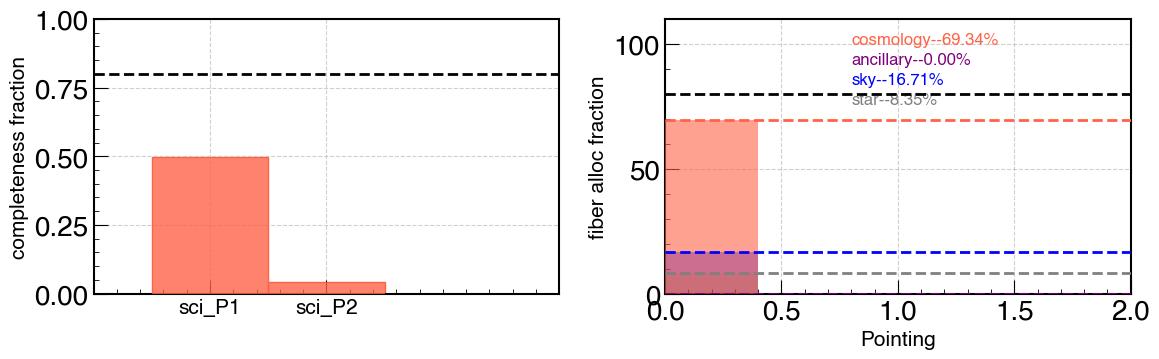

comp_out_tmp1 =  {'cal': 0.5235602094240838, 'sci_P1': 0.49644381223328593, 'sci_P2': 0.04130825219775026, 'sky': 0.006925447557048374}
1550.577274 secs passed after the visits done for field_a_L3_visit1.


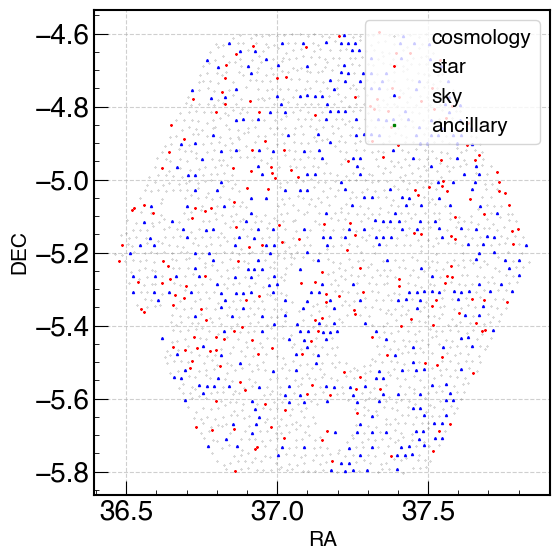

2025-01-17 16:53:24.240Z root             10 CoordTransp.py:306 0.0
2025-01-17 16:53:24.244Z root             20 DistortionCoefficients.py:688 2016.0
2025-01-17 16:53:24.245Z root             10 DistortionCoefficients.py:690 9.062970568104038 yr
2025-01-17 16:53:24.246Z root             10 DistortionCoefficients.py:701 1e-08 mas
/Users/jing/anaconda3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
2025-01-17 16:53:24.315Z root             20 DistortionCoefficients.py:709 Ra Dec = (35.85 -3.8) : original


field - a, L4 (35.850000, -3.800000): 88425 targets in the FoV.


2025-01-17 16:53:24.321Z root             20 DistortionCoefficients.py:711 PM = (0.0 mas / yr 0.0 mas / yr)
2025-01-17 16:53:24.323Z root             20 DistortionCoefficients.py:713 Ra Dec = (35.849999999999994 -3.8000000000000007) : applied proper motion
2025-01-17 16:53:24.325Z root             20 DistortionCoefficients.py:715 Ra Dec = (36.16574082497041 -3.6871402758626703) : applied presession
2025-01-17 16:53:24.418Z root             20 CoordTransp.py:312 FoV center: Ra,Dec=([35.85] [-3.8]) is Az,El,InR=(223.80306631528452 58.595524575171815 40.73213360459857)
/Users/jing/anaconda3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 88425 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
2025-01-17 16:53:24.833Z root             20 CoordTransp.py:84 Zenith angle for your field should be 31.404475424828185
2025-01-17 16:53:24.888Z root             20 CoordTransp.py:163 Correct extra dis

solving the problem for stage=0 targets.
Set parameter Presolve to value 1


2025-01-17 16:53:24.911Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-17 16:53:24.913Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-17 16:53:24.914Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-17 16:53:24.916Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-17 16:53:24.917Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-17 16:53:35.481Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-17 16:53:35.482Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-17 16:53:35.484Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-17 16:53:35.485Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-17 16:53:35.487Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-17 16:53:35.489Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 163958 rows, 80555 columns and 421006 nonzeros


2025-01-17 16:53:35.490Z gurobipy         20 netflow.py:149 Optimize a model with 163958 rows, 80555 columns and 421006 nonzeros


Model fingerprint: 0x9d1a42bd


2025-01-17 16:53:35.495Z gurobipy         20 netflow.py:149 Model fingerprint: 0x9d1a42bd


Variable types: 1 continuous, 80554 integer (80552 binary)


2025-01-17 16:53:35.497Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 80554 integer (80552 binary)


Coefficient statistics:


2025-01-17 16:53:35.500Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-17 16:53:35.502Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [2e-05, 1e+06]


2025-01-17 16:53:35.504Z gurobipy         20 netflow.py:149   Objective range  [2e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-17 16:53:35.505Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-17 16:53:35.507Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-17 16:53:35.527Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 163545 rows and 77956 columns


2025-01-17 16:53:36.316Z gurobipy         20 netflow.py:149 Presolve removed 163545 rows and 77956 columns


Presolve time: 0.77s


2025-01-17 16:53:36.317Z gurobipy         20 netflow.py:149 Presolve time: 0.77s


Presolved: 413 rows, 2599 columns, 3440 nonzeros


2025-01-17 16:53:36.324Z gurobipy         20 netflow.py:149 Presolved: 413 rows, 2599 columns, 3440 nonzeros


Found heuristic solution: objective 5.590000e+08


2025-01-17 16:53:36.330Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.590000e+08


Variable types: 0 continuous, 2599 integer (2597 binary)


2025-01-17 16:53:36.332Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 2599 integer (2597 binary)


Found heuristic solution: objective 5.570000e+08


2025-01-17 16:53:36.335Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.570000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-17 16:53:36.339Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-17 16:53:36.340Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-17 16:53:36.342Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-17 16:53:36.346Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-17 16:53:36.348Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-17 16:53:36.351Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-17 16:53:36.353Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-17 16:53:36.354Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 8.960e+02


2025-01-17 16:53:36.356Z gurobipy         20 netflow.py:149  AA' NZ     : 8.960e+02


 Factor NZ  : 1.902e+03 (roughly 1 MB of memory)


2025-01-17 16:53:36.357Z gurobipy         20 netflow.py:149  Factor NZ  : 1.902e+03 (roughly 1 MB of memory)


 Factor Ops : 1.675e+04 (less than 1 second per iteration)


2025-01-17 16:53:36.359Z gurobipy         20 netflow.py:149  Factor Ops : 1.675e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-17 16:53:36.360Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-17 16:53:36.362Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-17 16:53:36.363Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-17 16:53:36.365Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.18000743e+08 -2.66532216e+09  7.24e+00 4.18e+04  1.93e+07     1s


2025-01-17 16:53:36.367Z gurobipy         20 netflow.py:149    0   3.18000743e+08 -2.66532216e+09  7.24e+00 4.18e+04  1.93e+07     1s


2025-01-17 16:53:36.369Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.88 seconds (0.41 work units)


2025-01-17 16:53:36.370Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.88 seconds (0.41 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-17 16:53:36.372Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-17 16:53:36.374Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-17 16:53:36.376Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-17 16:53:36.377Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-17 16:53:36.379Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-17 16:53:36.381Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.181355e+01, 37 iterations, 0.04 seconds (0.00 work units)


2025-01-17 16:53:36.382Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.181355e+01, 37 iterations, 0.04 seconds (0.00 work units)


2025-01-17 16:53:36.388Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-17 16:53:36.390Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-17 16:53:36.391Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-17 16:53:36.393Z gurobipy         20 netflow.py:149 


*    0     0               0      11.8135498   11.81355  0.00%     -    0s


2025-01-17 16:53:36.394Z gurobipy         20 netflow.py:149 *    0     0               0      11.8135498   11.81355  0.00%     -    0s


2025-01-17 16:53:36.411Z gurobipy         20 netflow.py:149 


Explored 1 nodes (37 simplex iterations) in 0.92 seconds (0.41 work units)


2025-01-17 16:53:36.412Z gurobipy         20 netflow.py:149 Explored 1 nodes (37 simplex iterations) in 0.92 seconds (0.41 work units)


Thread count was 8 (of 8 available processors)


2025-01-17 16:53:36.414Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-17 16:53:36.415Z gurobipy         20 netflow.py:149 


Solution count 4: 11.8135 5.57e+08 5.59e+08 6e+08 


2025-01-17 16:53:36.417Z gurobipy         20 netflow.py:149 Solution count 4: 11.8135 5.57e+08 5.59e+08 6e+08 


2025-01-17 16:53:36.420Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-17 16:53:36.422Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.181354976972e+01, best bound 1.181354976972e+01, gap 0.0000%


2025-01-17 16:53:36.428Z gurobipy         20 netflow.py:149 Best objective 1.181354976972e+01, best bound 1.181354976972e+01, gap 0.0000%


Checking for trajectory collisions


2025-01-17 16:53:36.609Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-17 16:53:36.610Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:53:36.724Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:53:36.759Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:53:36.763Z engineer         20 engineer.py:395 Move theta arms to angle=[ 75.91 360.   360.   ... 210.2  360.   224.27] degree
2025-01-17 16:53:36.764Z engineer         20 engineer.py:396 Move phi arms to angle=[ 6.62 24.48 13.06 ...  8.33 11.99 14.19] degree
2025-01-17 16:53:36.764Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-17 16:53:36.765Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-17 16:53:36.791Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-17 16:53:36.816Z pfi              40 pfi.py:89

ERROR: detected 13 end point collision, which should be impossible
trajectory collisions found: 5
Set parameter Presolve to value 1


2025-01-17 16:53:45.155Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-17 16:53:45.156Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-17 16:53:45.157Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-17 16:53:45.159Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-17 16:53:45.162Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-17 16:53:56.510Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-17 16:53:56.511Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-17 16:53:56.513Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-17 16:53:56.514Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-17 16:53:56.516Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-17 16:53:56.519Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 163963 rows, 80555 columns and 421012 nonzeros


2025-01-17 16:53:56.521Z gurobipy         20 netflow.py:149 Optimize a model with 163963 rows, 80555 columns and 421012 nonzeros


Model fingerprint: 0x946b8a45


2025-01-17 16:53:56.526Z gurobipy         20 netflow.py:149 Model fingerprint: 0x946b8a45


Variable types: 1 continuous, 80554 integer (80552 binary)


2025-01-17 16:53:56.527Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 80554 integer (80552 binary)


Coefficient statistics:


2025-01-17 16:53:56.531Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-17 16:53:56.533Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [2e-05, 1e+06]


2025-01-17 16:53:56.535Z gurobipy         20 netflow.py:149   Objective range  [2e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-17 16:53:56.536Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-17 16:53:56.537Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-17 16:53:56.560Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 163551 rows and 77958 columns


2025-01-17 16:53:57.356Z gurobipy         20 netflow.py:149 Presolve removed 163551 rows and 77958 columns


Presolve time: 0.77s


2025-01-17 16:53:57.358Z gurobipy         20 netflow.py:149 Presolve time: 0.77s


Presolved: 412 rows, 2597 columns, 3436 nonzeros


2025-01-17 16:53:57.366Z gurobipy         20 netflow.py:149 Presolved: 412 rows, 2597 columns, 3436 nonzeros


Found heuristic solution: objective 5.580000e+08


2025-01-17 16:53:57.374Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.580000e+08


Variable types: 0 continuous, 2597 integer (2595 binary)


2025-01-17 16:53:57.377Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 2597 integer (2595 binary)


Found heuristic solution: objective 5.560000e+08


2025-01-17 16:53:57.382Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.560000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-17 16:53:57.388Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-17 16:53:57.391Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-17 16:53:57.393Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-17 16:53:57.397Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-17 16:53:57.399Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-17 16:53:57.402Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-17 16:53:57.405Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-17 16:53:57.410Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 8.940e+02


2025-01-17 16:53:57.415Z gurobipy         20 netflow.py:149  AA' NZ     : 8.940e+02


 Factor NZ  : 1.899e+03 (roughly 1 MB of memory)


2025-01-17 16:53:57.418Z gurobipy         20 netflow.py:149  Factor NZ  : 1.899e+03 (roughly 1 MB of memory)


 Factor Ops : 1.674e+04 (less than 1 second per iteration)


2025-01-17 16:53:57.419Z gurobipy         20 netflow.py:149  Factor Ops : 1.674e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-17 16:53:57.421Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-17 16:53:57.424Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-17 16:53:57.426Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-17 16:53:57.427Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.16765668e+08 -2.66468142e+09  7.10e+00 4.18e+04  1.90e+07     1s


2025-01-17 16:53:57.431Z gurobipy         20 netflow.py:149    0   3.16765668e+08 -2.66468142e+09  7.10e+00 4.18e+04  1.90e+07     1s


2025-01-17 16:53:57.434Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.92 seconds (0.41 work units)


2025-01-17 16:53:57.436Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.92 seconds (0.41 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-17 16:53:57.439Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-17 16:53:57.442Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.05s


2025-01-17 16:53:57.444Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.05s


2025-01-17 16:53:57.446Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-17 16:53:57.448Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-17 16:53:57.451Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.186240e+01, 38 iterations, 0.07 seconds (0.00 work units)


2025-01-17 16:53:57.454Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.186240e+01, 38 iterations, 0.07 seconds (0.00 work units)


2025-01-17 16:53:57.460Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-17 16:53:57.462Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-17 16:53:57.464Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-17 16:53:57.466Z gurobipy         20 netflow.py:149 


*    0     0               0      11.8623955   11.86240  0.00%     -    0s


2025-01-17 16:53:57.468Z gurobipy         20 netflow.py:149 *    0     0               0      11.8623955   11.86240  0.00%     -    0s


2025-01-17 16:53:57.489Z gurobipy         20 netflow.py:149 


Explored 1 nodes (38 simplex iterations) in 0.97 seconds (0.41 work units)


2025-01-17 16:53:57.491Z gurobipy         20 netflow.py:149 Explored 1 nodes (38 simplex iterations) in 0.97 seconds (0.41 work units)


Thread count was 8 (of 8 available processors)


2025-01-17 16:53:57.493Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-17 16:53:57.494Z gurobipy         20 netflow.py:149 


Solution count 4: 11.8624 5.56e+08 5.58e+08 6e+08 


2025-01-17 16:53:57.496Z gurobipy         20 netflow.py:149 Solution count 4: 11.8624 5.56e+08 5.58e+08 6e+08 


2025-01-17 16:53:57.498Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-17 16:53:57.500Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.186239547493e+01, best bound 1.186239547493e+01, gap 0.0000%


2025-01-17 16:53:57.505Z gurobipy         20 netflow.py:149 Best objective 1.186239547493e+01, best bound 1.186239547493e+01, gap 0.0000%


Checking for trajectory collisions


2025-01-17 16:53:57.680Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-17 16:53:57.682Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:53:57.812Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:53:57.848Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:53:57.851Z engineer         20 engineer.py:395 Move theta arms to angle=[ 75.91 360.   360.   ... 210.2  360.   224.27] degree
2025-01-17 16:53:57.853Z engineer         20 engineer.py:396 Move phi arms to angle=[ 6.62 24.48 13.06 ...  8.33 11.99 14.19] degree
2025-01-17 16:53:57.854Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-17 16:53:57.854Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-17 16:53:57.882Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-17 16:53:57.906Z pfi              40 pfi.py:89

ERROR: detected 11 end point collision, which should be impossible
trajectory collisions found: 3
Set parameter Presolve to value 1


2025-01-17 16:54:05.805Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-17 16:54:05.806Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-17 16:54:05.807Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-17 16:54:05.809Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-17 16:54:05.810Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-17 16:54:16.770Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-17 16:54:16.771Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-17 16:54:16.773Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-17 16:54:16.775Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-17 16:54:16.777Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-17 16:54:16.780Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 163966 rows, 80555 columns and 421015 nonzeros


2025-01-17 16:54:16.783Z gurobipy         20 netflow.py:149 Optimize a model with 163966 rows, 80555 columns and 421015 nonzeros


Model fingerprint: 0x1da9ea37


2025-01-17 16:54:16.789Z gurobipy         20 netflow.py:149 Model fingerprint: 0x1da9ea37


Variable types: 1 continuous, 80554 integer (80552 binary)


2025-01-17 16:54:16.791Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 80554 integer (80552 binary)


Coefficient statistics:


2025-01-17 16:54:16.795Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-17 16:54:16.797Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [2e-05, 1e+06]


2025-01-17 16:54:16.800Z gurobipy         20 netflow.py:149   Objective range  [2e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-17 16:54:16.802Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-17 16:54:16.803Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-17 16:54:16.894Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 163555 rows and 77960 columns


2025-01-17 16:54:17.699Z gurobipy         20 netflow.py:149 Presolve removed 163555 rows and 77960 columns


Presolve time: 0.77s


2025-01-17 16:54:17.700Z gurobipy         20 netflow.py:149 Presolve time: 0.77s


Presolved: 411 rows, 2595 columns, 3432 nonzeros


2025-01-17 16:54:17.707Z gurobipy         20 netflow.py:149 Presolved: 411 rows, 2595 columns, 3432 nonzeros


Found heuristic solution: objective 5.570000e+08


2025-01-17 16:54:17.713Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.570000e+08


Variable types: 0 continuous, 2595 integer (2593 binary)


2025-01-17 16:54:17.715Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 2595 integer (2593 binary)


Found heuristic solution: objective 5.550000e+08


2025-01-17 16:54:17.718Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.550000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-17 16:54:17.723Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-17 16:54:17.724Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-17 16:54:17.726Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-17 16:54:17.730Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-17 16:54:17.733Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-17 16:54:17.734Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-17 16:54:17.736Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-17 16:54:17.737Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 8.920e+02


2025-01-17 16:54:17.739Z gurobipy         20 netflow.py:149  AA' NZ     : 8.920e+02


 Factor NZ  : 1.896e+03 (roughly 1 MB of memory)


2025-01-17 16:54:17.741Z gurobipy         20 netflow.py:149  Factor NZ  : 1.896e+03 (roughly 1 MB of memory)


 Factor Ops : 1.673e+04 (less than 1 second per iteration)


2025-01-17 16:54:17.742Z gurobipy         20 netflow.py:149  Factor Ops : 1.673e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-17 16:54:17.744Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-17 16:54:17.747Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-17 16:54:17.751Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-17 16:54:17.754Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.15517945e+08 -2.66404061e+09  6.96e+00 4.19e+04  1.86e+07     1s


2025-01-17 16:54:17.758Z gurobipy         20 netflow.py:149    0   3.15517945e+08 -2.66404061e+09  6.96e+00 4.19e+04  1.86e+07     1s


2025-01-17 16:54:17.759Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.98 seconds (0.41 work units)


2025-01-17 16:54:17.761Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.98 seconds (0.41 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-17 16:54:17.763Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-17 16:54:17.766Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.04s


2025-01-17 16:54:17.768Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.04s


2025-01-17 16:54:17.770Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-17 16:54:17.772Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-17 16:54:17.775Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.187317e+01, 37 iterations, 0.05 seconds (0.00 work units)


2025-01-17 16:54:17.778Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.187317e+01, 37 iterations, 0.05 seconds (0.00 work units)


2025-01-17 16:54:17.783Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-17 16:54:17.786Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-17 16:54:17.787Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-17 16:54:17.790Z gurobipy         20 netflow.py:149 


*    0     0               0      11.8731746   11.87317  0.00%     -    1s


2025-01-17 16:54:17.792Z gurobipy         20 netflow.py:149 *    0     0               0      11.8731746   11.87317  0.00%     -    1s


2025-01-17 16:54:17.814Z gurobipy         20 netflow.py:149 


Explored 1 nodes (37 simplex iterations) in 1.04 seconds (0.41 work units)


2025-01-17 16:54:17.817Z gurobipy         20 netflow.py:149 Explored 1 nodes (37 simplex iterations) in 1.04 seconds (0.41 work units)


Thread count was 8 (of 8 available processors)


2025-01-17 16:54:17.818Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-17 16:54:17.820Z gurobipy         20 netflow.py:149 


Solution count 4: 11.8732 5.55e+08 5.57e+08 6e+08 


2025-01-17 16:54:17.822Z gurobipy         20 netflow.py:149 Solution count 4: 11.8732 5.55e+08 5.57e+08 6e+08 


2025-01-17 16:54:17.823Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-17 16:54:17.825Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.187317458930e+01, best bound 1.187317458930e+01, gap 0.0000%


2025-01-17 16:54:17.831Z gurobipy         20 netflow.py:149 Best objective 1.187317458930e+01, best bound 1.187317458930e+01, gap 0.0000%


Checking for trajectory collisions


2025-01-17 16:54:18.041Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-17 16:54:18.042Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:54:18.163Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:54:18.197Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:54:18.200Z engineer         20 engineer.py:395 Move theta arms to angle=[ 75.91 360.   360.   ... 210.2  360.   224.27] degree
2025-01-17 16:54:18.201Z engineer         20 engineer.py:396 Move phi arms to angle=[ 6.62 24.48 13.06 ...  8.33 11.99 14.19] degree
2025-01-17 16:54:18.202Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-17 16:54:18.203Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-17 16:54:18.231Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-17 16:54:18.254Z pfi              40 pfi.py:89

ERROR: detected 13 end point collision, which should be impossible
trajectory collisions found: 1
Set parameter Presolve to value 1


2025-01-17 16:54:25.841Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-17 16:54:25.842Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-17 16:54:25.843Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-17 16:54:25.845Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-17 16:54:25.847Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-17 16:54:38.510Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-17 16:54:38.511Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-17 16:54:38.512Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-17 16:54:38.515Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-17 16:54:38.517Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-17 16:54:38.540Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 163967 rows, 80555 columns and 421016 nonzeros


2025-01-17 16:54:38.602Z gurobipy         20 netflow.py:149 Optimize a model with 163967 rows, 80555 columns and 421016 nonzeros


Model fingerprint: 0xcd88969c


2025-01-17 16:54:38.625Z gurobipy         20 netflow.py:149 Model fingerprint: 0xcd88969c


Variable types: 1 continuous, 80554 integer (80552 binary)


2025-01-17 16:54:38.629Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 80554 integer (80552 binary)


Coefficient statistics:


2025-01-17 16:54:38.637Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-17 16:54:38.640Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [2e-05, 1e+06]


2025-01-17 16:54:38.642Z gurobipy         20 netflow.py:149   Objective range  [2e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-17 16:54:38.644Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-17 16:54:38.647Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-17 16:54:38.695Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 163556 rows and 77960 columns


2025-01-17 16:54:39.598Z gurobipy         20 netflow.py:149 Presolve removed 163556 rows and 77960 columns


Presolve time: 0.87s


2025-01-17 16:54:39.599Z gurobipy         20 netflow.py:149 Presolve time: 0.87s


Presolved: 411 rows, 2595 columns, 3432 nonzeros


2025-01-17 16:54:39.606Z gurobipy         20 netflow.py:149 Presolved: 411 rows, 2595 columns, 3432 nonzeros


Found heuristic solution: objective 5.570000e+08


2025-01-17 16:54:39.614Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.570000e+08


Variable types: 0 continuous, 2595 integer (2593 binary)


2025-01-17 16:54:39.617Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 2595 integer (2593 binary)


Found heuristic solution: objective 5.550000e+08


2025-01-17 16:54:39.621Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.550000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-17 16:54:39.626Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-17 16:54:39.629Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-17 16:54:39.631Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-17 16:54:39.635Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-17 16:54:39.637Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-17 16:54:39.639Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-17 16:54:39.640Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-17 16:54:39.642Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 8.920e+02


2025-01-17 16:54:39.644Z gurobipy         20 netflow.py:149  AA' NZ     : 8.920e+02


 Factor NZ  : 1.896e+03 (roughly 1 MB of memory)


2025-01-17 16:54:39.647Z gurobipy         20 netflow.py:149  Factor NZ  : 1.896e+03 (roughly 1 MB of memory)


 Factor Ops : 1.673e+04 (less than 1 second per iteration)


2025-01-17 16:54:39.648Z gurobipy         20 netflow.py:149  Factor Ops : 1.673e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-17 16:54:39.650Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-17 16:54:39.652Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-17 16:54:39.654Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-17 16:54:39.656Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.15517946e+08 -2.66404061e+09  6.96e+00 4.19e+04  1.86e+07     1s


2025-01-17 16:54:39.657Z gurobipy         20 netflow.py:149    0   3.15517946e+08 -2.66404061e+09  6.96e+00 4.19e+04  1.86e+07     1s


2025-01-17 16:54:39.659Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.14 seconds (0.41 work units)


2025-01-17 16:54:39.661Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.14 seconds (0.41 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-17 16:54:39.662Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-17 16:54:39.664Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-17 16:54:39.666Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-17 16:54:39.668Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-17 16:54:39.669Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-17 16:54:39.672Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.187835e+01, 37 iterations, 0.05 seconds (0.00 work units)


2025-01-17 16:54:39.675Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.187835e+01, 37 iterations, 0.05 seconds (0.00 work units)


2025-01-17 16:54:39.680Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-17 16:54:39.681Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-17 16:54:39.683Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-17 16:54:39.684Z gurobipy         20 netflow.py:149 


*    0     0               0      11.8783453   11.87835  0.00%     -    1s


2025-01-17 16:54:39.686Z gurobipy         20 netflow.py:149 *    0     0               0      11.8783453   11.87835  0.00%     -    1s


2025-01-17 16:54:39.704Z gurobipy         20 netflow.py:149 


Explored 1 nodes (37 simplex iterations) in 1.19 seconds (0.41 work units)


2025-01-17 16:54:39.706Z gurobipy         20 netflow.py:149 Explored 1 nodes (37 simplex iterations) in 1.19 seconds (0.41 work units)


Thread count was 8 (of 8 available processors)


2025-01-17 16:54:39.708Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-17 16:54:39.709Z gurobipy         20 netflow.py:149 


Solution count 4: 11.8783 5.55e+08 5.57e+08 6e+08 


2025-01-17 16:54:39.711Z gurobipy         20 netflow.py:149 Solution count 4: 11.8783 5.55e+08 5.57e+08 6e+08 


2025-01-17 16:54:39.712Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-17 16:54:39.714Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.187834526689e+01, best bound 1.187834526689e+01, gap 0.0000%


2025-01-17 16:54:39.719Z gurobipy         20 netflow.py:149 Best objective 1.187834526689e+01, best bound 1.187834526689e+01, gap 0.0000%


Checking for trajectory collisions


2025-01-17 16:54:39.911Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-17 16:54:39.912Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:54:40.029Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:54:40.063Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:54:40.066Z engineer         20 engineer.py:395 Move theta arms to angle=[ 75.91 360.   360.   ... 210.2  360.   224.27] degree
2025-01-17 16:54:40.067Z engineer         20 engineer.py:396 Move phi arms to angle=[ 6.62 24.48 13.06 ...  8.33 11.99 14.19] degree
2025-01-17 16:54:40.068Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-17 16:54:40.069Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-17 16:54:40.094Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-17 16:54:40.117Z pfi              40 pfi.py:89

ERROR: detected 13 end point collision, which should be impossible
trajectory collisions found: 0
Done: solving the problem for stage=0 targets.
solving the problem for stage=1 targets.
Set parameter Presolve to value 1


2025-01-17 16:54:47.666Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-17 16:54:47.668Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-17 16:54:47.669Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-17 16:54:47.670Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-17 16:54:47.671Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-17 16:54:54.898Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-17 16:54:54.900Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-17 16:54:54.901Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-17 16:54:54.902Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-17 16:54:54.904Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-17 16:54:54.906Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 99337 rows, 89861 columns and 271531 nonzeros


2025-01-17 16:54:54.908Z gurobipy         20 netflow.py:149 Optimize a model with 99337 rows, 89861 columns and 271531 nonzeros


Model fingerprint: 0x9b138ca3


2025-01-17 16:54:54.911Z gurobipy         20 netflow.py:149 Model fingerprint: 0x9b138ca3


Variable types: 1 continuous, 89860 integer (69113 binary)


2025-01-17 16:54:54.913Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 89860 integer (69113 binary)


Coefficient statistics:


2025-01-17 16:54:54.916Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-17 16:54:54.917Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [2e-05, 1e+06]


2025-01-17 16:54:54.919Z gurobipy         20 netflow.py:149   Objective range  [2e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-17 16:54:54.920Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-17 16:54:54.922Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 4214411.8783


2025-01-17 16:54:54.946Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4214411.8783


Presolve removed 99337 rows and 89861 columns


2025-01-17 16:54:55.155Z gurobipy         20 netflow.py:149 Presolve removed 99337 rows and 89861 columns


Presolve time: 0.21s


2025-01-17 16:54:55.157Z gurobipy         20 netflow.py:149 Presolve time: 0.21s


Presolve: All rows and columns removed


2025-01-17 16:54:55.163Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-17 16:54:55.174Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.27 seconds (0.13 work units)


2025-01-17 16:54:55.176Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.27 seconds (0.13 work units)


Thread count was 1 (of 8 available processors)


2025-01-17 16:54:55.177Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-17 16:54:55.179Z gurobipy         20 netflow.py:149 


Solution count 2: 3.84646e+06 4.21441e+06 


2025-01-17 16:54:55.180Z gurobipy         20 netflow.py:149 Solution count 2: 3.84646e+06 4.21441e+06 


2025-01-17 16:54:55.181Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-17 16:54:55.183Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 3.846457323990e+06, best bound 3.846457323990e+06, gap 0.0000%


2025-01-17 16:54:55.187Z gurobipy         20 netflow.py:149 Best objective 3.846457323990e+06, best bound 3.846457323990e+06, gap 0.0000%
2025-01-17 16:54:55.324Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-17 16:54:55.324Z pfi              40 pfi.py:899 Some phi angles are out of range


Checking for trajectory collisions


2025-01-17 16:54:55.437Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:54:55.472Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:54:55.476Z engineer         20 engineer.py:395 Move theta arms to angle=[ 75.91 333.02 131.97 ... 210.2  360.   224.27] degree
2025-01-17 16:54:55.477Z engineer         20 engineer.py:396 Move phi arms to angle=[ 6.62 42.74 10.15 ...  8.33 11.99 14.19] degree
2025-01-17 16:54:55.478Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-17 16:54:55.479Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-17 16:54:55.507Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-17 16:54:55.529Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:54:55.552Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:54:55.554Z engineer         20 engineer.py

ERROR: detected 19 end point collision, which should be impossible
trajectory collisions found: 24
Set parameter Presolve to value 1


2025-01-17 16:55:03.646Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-17 16:55:03.648Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-17 16:55:03.649Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-17 16:55:03.651Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-17 16:55:03.652Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-17 16:55:12.628Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-17 16:55:12.630Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-17 16:55:12.632Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-17 16:55:12.635Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-17 16:55:12.637Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-17 16:55:12.641Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 99362 rows, 89861 columns and 271566 nonzeros


2025-01-17 16:55:12.644Z gurobipy         20 netflow.py:149 Optimize a model with 99362 rows, 89861 columns and 271566 nonzeros


Model fingerprint: 0x983a73e7


2025-01-17 16:55:12.653Z gurobipy         20 netflow.py:149 Model fingerprint: 0x983a73e7


Variable types: 1 continuous, 89860 integer (69113 binary)


2025-01-17 16:55:12.655Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 89860 integer (69113 binary)


Coefficient statistics:


2025-01-17 16:55:12.660Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-17 16:55:12.664Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [2e-05, 1e+06]


2025-01-17 16:55:12.667Z gurobipy         20 netflow.py:149   Objective range  [2e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-17 16:55:12.673Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-17 16:55:12.677Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 4214411.8783


2025-01-17 16:55:12.752Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4214411.8783


Presolve removed 99362 rows and 89861 columns


2025-01-17 16:55:13.011Z gurobipy         20 netflow.py:149 Presolve removed 99362 rows and 89861 columns


Presolve time: 0.26s


2025-01-17 16:55:13.013Z gurobipy         20 netflow.py:149 Presolve time: 0.26s


Presolve: All rows and columns removed


2025-01-17 16:55:13.026Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-17 16:55:13.039Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.40 seconds (0.13 work units)


2025-01-17 16:55:13.041Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.40 seconds (0.13 work units)


Thread count was 1 (of 8 available processors)


2025-01-17 16:55:13.042Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-17 16:55:13.045Z gurobipy         20 netflow.py:149 


Solution count 2: 3.84686e+06 4.21441e+06 


2025-01-17 16:55:13.047Z gurobipy         20 netflow.py:149 Solution count 2: 3.84686e+06 4.21441e+06 


2025-01-17 16:55:13.048Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-17 16:55:13.050Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 3.846857455637e+06, best bound 3.846857455637e+06, gap 0.0000%


2025-01-17 16:55:13.055Z gurobipy         20 netflow.py:149 Best objective 3.846857455637e+06, best bound 3.846857455637e+06, gap 0.0000%
2025-01-17 16:55:13.209Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-17 16:55:13.210Z pfi              40 pfi.py:899 Some phi angles are out of range


Checking for trajectory collisions


2025-01-17 16:55:13.341Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:55:13.375Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:55:13.378Z engineer         20 engineer.py:395 Move theta arms to angle=[ 75.91 333.02 131.97 ... 210.2  360.   224.27] degree
2025-01-17 16:55:13.379Z engineer         20 engineer.py:396 Move phi arms to angle=[ 6.62 42.74 10.15 ...  8.33 11.99 14.19] degree
2025-01-17 16:55:13.380Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-17 16:55:13.381Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-17 16:55:13.408Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-17 16:55:13.434Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:55:13.457Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:55:13.459Z engineer         20 engineer.py

ERROR: detected 17 end point collision, which should be impossible
trajectory collisions found: 22
Set parameter Presolve to value 1


2025-01-17 16:55:21.883Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-17 16:55:21.884Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-17 16:55:21.885Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-17 16:55:21.887Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-17 16:55:21.889Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-17 16:55:30.085Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-17 16:55:30.086Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-17 16:55:30.087Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-17 16:55:30.089Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-17 16:55:30.090Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-17 16:55:30.093Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 99385 rows, 89861 columns and 271594 nonzeros


2025-01-17 16:55:30.094Z gurobipy         20 netflow.py:149 Optimize a model with 99385 rows, 89861 columns and 271594 nonzeros


Model fingerprint: 0x0f5bfc20


2025-01-17 16:55:30.098Z gurobipy         20 netflow.py:149 Model fingerprint: 0x0f5bfc20


Variable types: 1 continuous, 89860 integer (69113 binary)


2025-01-17 16:55:30.099Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 89860 integer (69113 binary)


Coefficient statistics:


2025-01-17 16:55:30.103Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-17 16:55:30.104Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [2e-05, 1e+06]


2025-01-17 16:55:30.106Z gurobipy         20 netflow.py:149   Objective range  [2e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-17 16:55:30.107Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-17 16:55:30.109Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 4214411.8783


2025-01-17 16:55:30.133Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4214411.8783


Presolve removed 99385 rows and 89861 columns


2025-01-17 16:55:30.346Z gurobipy         20 netflow.py:149 Presolve removed 99385 rows and 89861 columns


Presolve time: 0.21s


2025-01-17 16:55:30.347Z gurobipy         20 netflow.py:149 Presolve time: 0.21s


Presolve: All rows and columns removed


2025-01-17 16:55:30.353Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-17 16:55:30.363Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.27 seconds (0.13 work units)


2025-01-17 16:55:30.365Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.27 seconds (0.13 work units)


Thread count was 1 (of 8 available processors)


2025-01-17 16:55:30.366Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-17 16:55:30.368Z gurobipy         20 netflow.py:149 


Solution count 2: 3.84686e+06 4.21441e+06 


2025-01-17 16:55:30.369Z gurobipy         20 netflow.py:149 Solution count 2: 3.84686e+06 4.21441e+06 


2025-01-17 16:55:30.371Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-17 16:55:30.372Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 3.846857596384e+06, best bound 3.846857596384e+06, gap 0.0000%


2025-01-17 16:55:30.376Z gurobipy         20 netflow.py:149 Best objective 3.846857596384e+06, best bound 3.846857596384e+06, gap 0.0000%
2025-01-17 16:55:30.515Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-17 16:55:30.516Z pfi              40 pfi.py:899 Some phi angles are out of range


Checking for trajectory collisions


2025-01-17 16:55:30.628Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:55:30.663Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:55:30.666Z engineer         20 engineer.py:395 Move theta arms to angle=[ 75.91 333.02 131.97 ... 210.2  360.   224.27] degree
2025-01-17 16:55:30.667Z engineer         20 engineer.py:396 Move phi arms to angle=[ 6.62 42.74 10.15 ...  8.33 11.99 14.19] degree
2025-01-17 16:55:30.668Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-17 16:55:30.669Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-17 16:55:30.693Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-17 16:55:30.716Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:55:30.738Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:55:30.740Z engineer         20 engineer.py

ERROR: detected 11 end point collision, which should be impossible
trajectory collisions found: 17
Set parameter Presolve to value 1


2025-01-17 16:55:38.448Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-17 16:55:38.449Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-17 16:55:38.450Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-17 16:55:38.452Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-17 16:55:38.454Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-17 16:55:45.902Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-17 16:55:45.903Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-17 16:55:45.904Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-17 16:55:45.905Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-17 16:55:45.907Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-17 16:55:45.909Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 99402 rows, 89861 columns and 271618 nonzeros


2025-01-17 16:55:45.910Z gurobipy         20 netflow.py:149 Optimize a model with 99402 rows, 89861 columns and 271618 nonzeros


Model fingerprint: 0x4a0f778e


2025-01-17 16:55:45.914Z gurobipy         20 netflow.py:149 Model fingerprint: 0x4a0f778e


Variable types: 1 continuous, 89860 integer (69113 binary)


2025-01-17 16:55:45.916Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 89860 integer (69113 binary)


Coefficient statistics:


2025-01-17 16:55:45.919Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-17 16:55:45.921Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [2e-05, 1e+06]


2025-01-17 16:55:45.922Z gurobipy         20 netflow.py:149   Objective range  [2e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-17 16:55:45.924Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-17 16:55:45.925Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 4214411.8783


2025-01-17 16:55:45.951Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4214411.8783


Presolve removed 99402 rows and 89861 columns


2025-01-17 16:55:46.164Z gurobipy         20 netflow.py:149 Presolve removed 99402 rows and 89861 columns


Presolve time: 0.21s


2025-01-17 16:55:46.165Z gurobipy         20 netflow.py:149 Presolve time: 0.21s


Presolve: All rows and columns removed


2025-01-17 16:55:46.170Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-17 16:55:46.180Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.27 seconds (0.13 work units)


2025-01-17 16:55:46.182Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.27 seconds (0.13 work units)


Thread count was 1 (of 8 available processors)


2025-01-17 16:55:46.183Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-17 16:55:46.184Z gurobipy         20 netflow.py:149 


Solution count 2: 3.84686e+06 4.21441e+06 


2025-01-17 16:55:46.186Z gurobipy         20 netflow.py:149 Solution count 2: 3.84686e+06 4.21441e+06 


2025-01-17 16:55:46.187Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-17 16:55:46.188Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 3.846857708394e+06, best bound 3.846857708394e+06, gap 0.0000%


2025-01-17 16:55:46.192Z gurobipy         20 netflow.py:149 Best objective 3.846857708394e+06, best bound 3.846857708394e+06, gap 0.0000%
2025-01-17 16:55:46.343Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-17 16:55:46.344Z pfi              40 pfi.py:899 Some phi angles are out of range


Checking for trajectory collisions


2025-01-17 16:55:46.458Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:55:46.492Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:55:46.495Z engineer         20 engineer.py:395 Move theta arms to angle=[ 75.91 333.02 131.97 ... 210.2  360.   224.27] degree
2025-01-17 16:55:46.496Z engineer         20 engineer.py:396 Move phi arms to angle=[ 6.62 42.74 10.15 ...  8.33 11.99 14.19] degree
2025-01-17 16:55:46.497Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-17 16:55:46.497Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-17 16:55:46.523Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-17 16:55:46.546Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:55:46.568Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:55:46.570Z engineer         20 engineer.py

ERROR: detected 13 end point collision, which should be impossible
trajectory collisions found: 17
Set parameter Presolve to value 1


2025-01-17 16:55:54.198Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-17 16:55:54.201Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-17 16:55:54.204Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-17 16:55:54.205Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-17 16:55:54.207Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-17 16:56:03.456Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-17 16:56:03.458Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-17 16:56:03.460Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-17 16:56:03.462Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-17 16:56:03.464Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-17 16:56:03.467Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 99419 rows, 89861 columns and 271647 nonzeros


2025-01-17 16:56:03.468Z gurobipy         20 netflow.py:149 Optimize a model with 99419 rows, 89861 columns and 271647 nonzeros


Model fingerprint: 0x2b4a1072


2025-01-17 16:56:03.472Z gurobipy         20 netflow.py:149 Model fingerprint: 0x2b4a1072


Variable types: 1 continuous, 89860 integer (69113 binary)


2025-01-17 16:56:03.474Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 89860 integer (69113 binary)


Coefficient statistics:


2025-01-17 16:56:03.478Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-17 16:56:03.479Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [2e-05, 1e+06]


2025-01-17 16:56:03.481Z gurobipy         20 netflow.py:149   Objective range  [2e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-17 16:56:03.482Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-17 16:56:03.486Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 4214411.8783


2025-01-17 16:56:03.518Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4214411.8783


Presolve removed 99419 rows and 89861 columns


2025-01-17 16:56:03.821Z gurobipy         20 netflow.py:149 Presolve removed 99419 rows and 89861 columns


Presolve time: 0.30s


2025-01-17 16:56:03.825Z gurobipy         20 netflow.py:149 Presolve time: 0.30s


Presolve: All rows and columns removed


2025-01-17 16:56:03.833Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-17 16:56:03.845Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.38 seconds (0.13 work units)


2025-01-17 16:56:03.846Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.38 seconds (0.13 work units)


Thread count was 1 (of 8 available processors)


2025-01-17 16:56:03.848Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-17 16:56:03.850Z gurobipy         20 netflow.py:149 


Solution count 2: 3.84686e+06 4.21441e+06 


2025-01-17 16:56:03.851Z gurobipy         20 netflow.py:149 Solution count 2: 3.84686e+06 4.21441e+06 


2025-01-17 16:56:03.853Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-17 16:56:03.854Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 3.846857762627e+06, best bound 3.846857762627e+06, gap 0.0000%


2025-01-17 16:56:03.858Z gurobipy         20 netflow.py:149 Best objective 3.846857762627e+06, best bound 3.846857762627e+06, gap 0.0000%
2025-01-17 16:56:04.005Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-17 16:56:04.007Z pfi              40 pfi.py:899 Some phi angles are out of range


Checking for trajectory collisions


2025-01-17 16:56:04.148Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:56:04.183Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:56:04.186Z engineer         20 engineer.py:395 Move theta arms to angle=[ 75.91 333.02 131.97 ... 210.2  360.   224.27] degree
2025-01-17 16:56:04.187Z engineer         20 engineer.py:396 Move phi arms to angle=[ 6.62 42.74 10.15 ...  8.33 11.99 14.19] degree
2025-01-17 16:56:04.189Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-17 16:56:04.190Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-17 16:56:04.216Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-17 16:56:04.238Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:56:04.275Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:56:04.277Z engineer         20 engineer.py

ERROR: detected 11 end point collision, which should be impossible
trajectory collisions found: 15
Set parameter Presolve to value 1


2025-01-17 16:56:12.629Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-17 16:56:12.633Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-17 16:56:12.635Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-17 16:56:12.643Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-17 16:56:12.648Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-17 16:56:21.417Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-17 16:56:21.419Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-17 16:56:21.421Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-17 16:56:21.424Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-17 16:56:21.426Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-17 16:56:21.429Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 99434 rows, 89861 columns and 271671 nonzeros


2025-01-17 16:56:21.432Z gurobipy         20 netflow.py:149 Optimize a model with 99434 rows, 89861 columns and 271671 nonzeros


Model fingerprint: 0x38971af6


2025-01-17 16:56:21.436Z gurobipy         20 netflow.py:149 Model fingerprint: 0x38971af6


Variable types: 1 continuous, 89860 integer (69113 binary)


2025-01-17 16:56:21.438Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 89860 integer (69113 binary)


Coefficient statistics:


2025-01-17 16:56:21.442Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-17 16:56:21.443Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [2e-05, 1e+06]


2025-01-17 16:56:21.445Z gurobipy         20 netflow.py:149   Objective range  [2e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-17 16:56:21.447Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-17 16:56:21.449Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 4214411.8783


2025-01-17 16:56:21.477Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4214411.8783


Presolve removed 99434 rows and 89861 columns


2025-01-17 16:56:21.683Z gurobipy         20 netflow.py:149 Presolve removed 99434 rows and 89861 columns


Presolve time: 0.20s


2025-01-17 16:56:21.685Z gurobipy         20 netflow.py:149 Presolve time: 0.20s


Presolve: All rows and columns removed


2025-01-17 16:56:21.690Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-17 16:56:21.701Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.27 seconds (0.13 work units)


2025-01-17 16:56:21.703Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.27 seconds (0.13 work units)


Thread count was 1 (of 8 available processors)


2025-01-17 16:56:21.704Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-17 16:56:21.706Z gurobipy         20 netflow.py:149 


Solution count 2: 3.84706e+06 4.21441e+06 


2025-01-17 16:56:21.708Z gurobipy         20 netflow.py:149 Solution count 2: 3.84706e+06 4.21441e+06 


2025-01-17 16:56:21.710Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-17 16:56:21.711Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 3.847057761078e+06, best bound 3.847057761078e+06, gap 0.0000%


2025-01-17 16:56:21.716Z gurobipy         20 netflow.py:149 Best objective 3.847057761078e+06, best bound 3.847057761078e+06, gap 0.0000%


Checking for trajectory collisions


2025-01-17 16:56:21.905Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-17 16:56:21.906Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:56:22.030Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:56:22.065Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:56:22.068Z engineer         20 engineer.py:395 Move theta arms to angle=[ 75.91 333.02 131.97 ... 210.2  360.   224.27] degree
2025-01-17 16:56:22.069Z engineer         20 engineer.py:396 Move phi arms to angle=[ 6.62 42.74 10.15 ...  8.33 11.99 14.19] degree
2025-01-17 16:56:22.070Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-17 16:56:22.070Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-17 16:56:22.095Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-17 16:56:22.118Z pfi              40 pfi.py:89

ERROR: detected 7 end point collision, which should be impossible
trajectory collisions found: 13
Set parameter Presolve to value 1


2025-01-17 16:56:30.546Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-17 16:56:30.548Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-17 16:56:30.553Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-17 16:56:30.556Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-17 16:56:30.560Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-17 16:56:38.753Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-17 16:56:38.755Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-17 16:56:38.756Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-17 16:56:38.757Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-17 16:56:38.759Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-17 16:56:38.761Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 99447 rows, 89861 columns and 271693 nonzeros


2025-01-17 16:56:38.762Z gurobipy         20 netflow.py:149 Optimize a model with 99447 rows, 89861 columns and 271693 nonzeros


Model fingerprint: 0x3ad5d3db


2025-01-17 16:56:38.766Z gurobipy         20 netflow.py:149 Model fingerprint: 0x3ad5d3db


Variable types: 1 continuous, 89860 integer (69113 binary)


2025-01-17 16:56:38.768Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 89860 integer (69113 binary)


Coefficient statistics:


2025-01-17 16:56:38.771Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-17 16:56:38.773Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [2e-05, 1e+06]


2025-01-17 16:56:38.774Z gurobipy         20 netflow.py:149   Objective range  [2e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-17 16:56:38.776Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-17 16:56:38.777Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 4214411.8783


2025-01-17 16:56:38.800Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4214411.8783


Presolve removed 99447 rows and 89861 columns


2025-01-17 16:56:39.011Z gurobipy         20 netflow.py:149 Presolve removed 99447 rows and 89861 columns


Presolve time: 0.21s


2025-01-17 16:56:39.013Z gurobipy         20 netflow.py:149 Presolve time: 0.21s


Presolve: All rows and columns removed


2025-01-17 16:56:39.019Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-17 16:56:39.029Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.27 seconds (0.13 work units)


2025-01-17 16:56:39.031Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.27 seconds (0.13 work units)


Thread count was 1 (of 8 available processors)


2025-01-17 16:56:39.033Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-17 16:56:39.035Z gurobipy         20 netflow.py:149 


Solution count 2: 3.84726e+06 4.21441e+06 


2025-01-17 16:56:39.036Z gurobipy         20 netflow.py:149 Solution count 2: 3.84726e+06 4.21441e+06 


2025-01-17 16:56:39.038Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-17 16:56:39.039Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 3.847257717512e+06, best bound 3.847257717512e+06, gap 0.0000%


2025-01-17 16:56:39.043Z gurobipy         20 netflow.py:149 Best objective 3.847257717512e+06, best bound 3.847257717512e+06, gap 0.0000%
2025-01-17 16:56:39.177Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-17 16:56:39.178Z pfi              40 pfi.py:899 Some phi angles are out of range


Checking for trajectory collisions


2025-01-17 16:56:39.288Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:56:39.324Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:56:39.327Z engineer         20 engineer.py:395 Move theta arms to angle=[ 75.91 333.02 131.97 ... 210.2  360.   224.27] degree
2025-01-17 16:56:39.328Z engineer         20 engineer.py:396 Move phi arms to angle=[ 6.62 42.74 10.15 ...  8.33 11.99 14.19] degree
2025-01-17 16:56:39.329Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-17 16:56:39.329Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-17 16:56:39.356Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-17 16:56:39.378Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:56:39.401Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:56:39.403Z engineer         20 engineer.py

ERROR: detected 13 end point collision, which should be impossible
trajectory collisions found: 12
Set parameter Presolve to value 1


2025-01-17 16:56:47.432Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-17 16:56:47.434Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-17 16:56:47.435Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-17 16:56:47.436Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-17 16:56:47.437Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-17 16:56:56.134Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-17 16:56:56.135Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-17 16:56:56.137Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-17 16:56:56.138Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-17 16:56:56.140Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-17 16:56:56.142Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 99459 rows, 89861 columns and 271716 nonzeros


2025-01-17 16:56:56.143Z gurobipy         20 netflow.py:149 Optimize a model with 99459 rows, 89861 columns and 271716 nonzeros


Model fingerprint: 0xc878ad41


2025-01-17 16:56:56.147Z gurobipy         20 netflow.py:149 Model fingerprint: 0xc878ad41


Variable types: 1 continuous, 89860 integer (69113 binary)


2025-01-17 16:56:56.150Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 89860 integer (69113 binary)


Coefficient statistics:


2025-01-17 16:56:56.154Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-17 16:56:56.156Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [2e-05, 1e+06]


2025-01-17 16:56:56.158Z gurobipy         20 netflow.py:149   Objective range  [2e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-17 16:56:56.160Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-17 16:56:56.162Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 4214411.8783


2025-01-17 16:56:56.190Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4214411.8783


Presolve removed 99459 rows and 89861 columns


2025-01-17 16:56:56.401Z gurobipy         20 netflow.py:149 Presolve removed 99459 rows and 89861 columns


Presolve time: 0.21s


2025-01-17 16:56:56.403Z gurobipy         20 netflow.py:149 Presolve time: 0.21s


Presolve: All rows and columns removed


2025-01-17 16:56:56.408Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-17 16:56:56.418Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.28 seconds (0.13 work units)


2025-01-17 16:56:56.419Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.28 seconds (0.13 work units)


Thread count was 1 (of 8 available processors)


2025-01-17 16:56:56.421Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-17 16:56:56.422Z gurobipy         20 netflow.py:149 


Solution count 2: 3.84746e+06 4.21441e+06 


2025-01-17 16:56:56.423Z gurobipy         20 netflow.py:149 Solution count 2: 3.84746e+06 4.21441e+06 


2025-01-17 16:56:56.425Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-17 16:56:56.426Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 3.847457664168e+06, best bound 3.847457664168e+06, gap 0.0000%


2025-01-17 16:56:56.430Z gurobipy         20 netflow.py:149 Best objective 3.847457664168e+06, best bound 3.847457664168e+06, gap 0.0000%
2025-01-17 16:56:56.564Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-17 16:56:56.565Z pfi              40 pfi.py:899 Some phi angles are out of range


Checking for trajectory collisions


2025-01-17 16:56:56.678Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:56:56.713Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:56:56.716Z engineer         20 engineer.py:395 Move theta arms to angle=[ 75.91 333.02 131.97 ... 210.2  360.   224.27] degree
2025-01-17 16:56:56.718Z engineer         20 engineer.py:396 Move phi arms to angle=[ 6.62 42.74 10.15 ...  8.33 11.99 14.19] degree
2025-01-17 16:56:56.718Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-17 16:56:56.719Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-17 16:56:56.744Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-17 16:56:56.768Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:56:56.790Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:56:56.792Z engineer         20 engineer.py

ERROR: detected 11 end point collision, which should be impossible
trajectory collisions found: 11
Set parameter Presolve to value 1


2025-01-17 16:57:04.531Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-17 16:57:04.532Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-17 16:57:04.534Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-17 16:57:04.535Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-17 16:57:04.536Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-17 16:57:12.809Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-17 16:57:12.811Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-17 16:57:12.813Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-17 16:57:12.815Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-17 16:57:12.818Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-17 16:57:12.820Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 99471 rows, 89861 columns and 271740 nonzeros


2025-01-17 16:57:12.822Z gurobipy         20 netflow.py:149 Optimize a model with 99471 rows, 89861 columns and 271740 nonzeros


Model fingerprint: 0xbb1a1d9a


2025-01-17 16:57:12.826Z gurobipy         20 netflow.py:149 Model fingerprint: 0xbb1a1d9a


Variable types: 1 continuous, 89860 integer (69113 binary)


2025-01-17 16:57:12.828Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 89860 integer (69113 binary)


Coefficient statistics:


2025-01-17 16:57:12.832Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-17 16:57:12.833Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [2e-05, 1e+06]


2025-01-17 16:57:12.835Z gurobipy         20 netflow.py:149   Objective range  [2e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-17 16:57:12.837Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-17 16:57:12.839Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 4214411.8783


2025-01-17 16:57:12.865Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4214411.8783


Presolve removed 99471 rows and 89861 columns


2025-01-17 16:57:13.114Z gurobipy         20 netflow.py:149 Presolve removed 99471 rows and 89861 columns


Presolve time: 0.25s


2025-01-17 16:57:13.116Z gurobipy         20 netflow.py:149 Presolve time: 0.25s


Presolve: All rows and columns removed


2025-01-17 16:57:13.131Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-17 16:57:13.150Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.33 seconds (0.14 work units)


2025-01-17 16:57:13.152Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.33 seconds (0.14 work units)


Thread count was 1 (of 8 available processors)


2025-01-17 16:57:13.153Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-17 16:57:13.155Z gurobipy         20 netflow.py:149 


Solution count 2: 3.84746e+06 4.21441e+06 


2025-01-17 16:57:13.156Z gurobipy         20 netflow.py:149 Solution count 2: 3.84746e+06 4.21441e+06 


2025-01-17 16:57:13.158Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-17 16:57:13.159Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 3.847457711228e+06, best bound 3.847457711228e+06, gap 0.0000%


2025-01-17 16:57:13.163Z gurobipy         20 netflow.py:149 Best objective 3.847457711228e+06, best bound 3.847457711228e+06, gap 0.0000%
2025-01-17 16:57:13.301Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-17 16:57:13.302Z pfi              40 pfi.py:899 Some phi angles are out of range


Checking for trajectory collisions


2025-01-17 16:57:13.416Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:57:13.456Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:57:13.460Z engineer         20 engineer.py:395 Move theta arms to angle=[ 75.91 333.02 131.97 ... 210.2  360.   224.27] degree
2025-01-17 16:57:13.461Z engineer         20 engineer.py:396 Move phi arms to angle=[ 6.62 42.74 10.15 ...  8.33 11.99 14.19] degree
2025-01-17 16:57:13.462Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-17 16:57:13.462Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-17 16:57:13.487Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-17 16:57:13.510Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:57:13.532Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:57:13.534Z engineer         20 engineer.py

ERROR: detected 11 end point collision, which should be impossible
trajectory collisions found: 11
Set parameter Presolve to value 1


2025-01-17 16:57:21.496Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-17 16:57:21.498Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-17 16:57:21.499Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-17 16:57:21.501Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-17 16:57:21.502Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-17 16:57:29.918Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-17 16:57:29.919Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-17 16:57:29.921Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-17 16:57:29.922Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-17 16:57:29.924Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-17 16:57:29.926Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 99484 rows, 89861 columns and 271769 nonzeros


2025-01-17 16:57:29.927Z gurobipy         20 netflow.py:149 Optimize a model with 99484 rows, 89861 columns and 271769 nonzeros


Model fingerprint: 0x684e8c23


2025-01-17 16:57:29.931Z gurobipy         20 netflow.py:149 Model fingerprint: 0x684e8c23


Variable types: 1 continuous, 89860 integer (69113 binary)


2025-01-17 16:57:29.933Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 89860 integer (69113 binary)


Coefficient statistics:


2025-01-17 16:57:29.936Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-17 16:57:29.938Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [2e-05, 1e+06]


2025-01-17 16:57:29.939Z gurobipy         20 netflow.py:149   Objective range  [2e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-17 16:57:29.940Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-17 16:57:29.942Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Found heuristic solution: objective 4214411.8783


2025-01-17 16:57:29.969Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4214411.8783


Presolve removed 99484 rows and 89861 columns


2025-01-17 16:57:30.226Z gurobipy         20 netflow.py:149 Presolve removed 99484 rows and 89861 columns


Presolve time: 0.26s


2025-01-17 16:57:30.228Z gurobipy         20 netflow.py:149 Presolve time: 0.26s


Presolve: All rows and columns removed


2025-01-17 16:57:30.233Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-17 16:57:30.245Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.32 seconds (0.14 work units)


2025-01-17 16:57:30.248Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.32 seconds (0.14 work units)


Thread count was 1 (of 8 available processors)


2025-01-17 16:57:30.251Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-17 16:57:30.253Z gurobipy         20 netflow.py:149 


Solution count 2: 3.84766e+06 4.21441e+06 


2025-01-17 16:57:30.254Z gurobipy         20 netflow.py:149 Solution count 2: 3.84766e+06 4.21441e+06 


2025-01-17 16:57:30.256Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-17 16:57:30.257Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 3.847657660097e+06, best bound 3.847657660097e+06, gap 0.0000%


2025-01-17 16:57:30.261Z gurobipy         20 netflow.py:149 Best objective 3.847657660097e+06, best bound 3.847657660097e+06, gap 0.0000%
2025-01-17 16:57:30.395Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-17 16:57:30.396Z pfi              40 pfi.py:899 Some phi angles are out of range


Checking for trajectory collisions


2025-01-17 16:57:30.513Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:57:30.550Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:57:30.553Z engineer         20 engineer.py:395 Move theta arms to angle=[ 75.91 333.02 131.97 ... 210.2  360.   224.27] degree
2025-01-17 16:57:30.554Z engineer         20 engineer.py:396 Move phi arms to angle=[ 6.62 42.74 10.15 ...  8.33 11.99 14.19] degree
2025-01-17 16:57:30.554Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-17 16:57:30.555Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-17 16:57:30.580Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-17 16:57:30.603Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:57:30.625Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-17 16:57:30.627Z engineer         20 engineer.py

ERROR: detected 15 end point collision, which should be impossible
trajectory collisions found: 11
Set parameter Presolve to value 1


2025-01-17 16:57:38.291Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-17 16:57:38.293Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-17 16:57:38.294Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-17 16:57:38.295Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-17 16:57:38.297Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-17 16:57:46.036Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-17 16:57:46.038Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-17 16:57:46.040Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-17 16:57:46.042Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-17 16:57:46.043Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-17 16:57:46.047Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 99498 rows, 89861 columns and 271800 nonzeros


2025-01-17 16:57:46.049Z gurobipy         20 netflow.py:149 Optimize a model with 99498 rows, 89861 columns and 271800 nonzeros


Model fingerprint: 0x52e1b76d


2025-01-17 16:57:46.054Z gurobipy         20 netflow.py:149 Model fingerprint: 0x52e1b76d


Variable types: 1 continuous, 89860 integer (69113 binary)


2025-01-17 16:57:46.056Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 89860 integer (69113 binary)


Coefficient statistics:


2025-01-17 16:57:46.060Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-17 16:57:46.062Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [2e-05, 1e+06]


2025-01-17 16:57:46.064Z gurobipy         20 netflow.py:149   Objective range  [2e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-17 16:57:46.066Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+04]


2025-01-17 16:57:46.068Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+04]


Presolve removed 21344 rows and 42041 columns


2025-01-17 16:57:46.161Z gurobipy         20 netflow.py:149 Presolve removed 21344 rows and 42041 columns


Presolve time: 0.05s


2025-01-17 16:57:46.162Z gurobipy         20 netflow.py:149 Presolve time: 0.05s


2025-01-17 16:57:46.168Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.12 seconds (0.06 work units)


2025-01-17 16:57:46.169Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.12 seconds (0.06 work units)


Thread count was 1 (of 8 available processors)


2025-01-17 16:57:46.170Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-17 16:57:46.172Z gurobipy         20 netflow.py:149 


Solution count 0


2025-01-17 16:57:46.173Z gurobipy         20 netflow.py:149 Solution count 0


2025-01-17 16:57:46.175Z gurobipy         20 netflow.py:149 


Model is infeasible


2025-01-17 16:57:46.176Z gurobipy         20 netflow.py:149 Model is infeasible


Best objective -, best bound -, gap -


2025-01-17 16:57:46.177Z gurobipy         20 netflow.py:149 Best objective -, best bound -, gap -


AttributeError: Unable to retrieve attribute 'X'

In [12]:
# prefix = 'cmx_01222025_DESI-ELG'
fdir_Jan25 = '../data_raw/Jan25/'
prefix_org = 'cmx_01222025_DESI-ELG'
outdir = '../output/Jan25/'
data_dir = '../data_proc/Jan25/'
prefix = ''

# HST(UTC-10) Jan 22 20:00 for field a and b, same for both visits
otime_list = ['2025-01-23T06:00:00Z', '2025-01-23T06:00:00Z']
 
#for field, Li_list, otime in zip(['a', 'b'], [['L1', 'L3', 'L4'], ['L1', 'L2', 'L3']], otime_list):
for field, Li_list, otime in zip(['a', ], [['L1', 'L3', 'L4'], ], ['2025-01-23T06:00:00Z', ]):
    pointings = read_proc_pointings_Jan25(fdir_Jan25, data_dir, prefix_org, field)
    print(pointings)

    # cosmology + sky + star targets
    fn_list = ['field_{}_targets.ecsv'.format(field), 'star_field_{}_targets.ecsv'.format(field), 'sky_field_{}_targets.ecsv'.format(field)]
    prefix_list = ["sci", "cal", "sky"]
    calibration_list = [False, True, True]

    # telescope parameters
    tele_params = {"otime": otime, "posang":0.}

    # first visit
    visit = 1
    main(outdir, data_dir, True, pointings, prefix, field, Li_list, visit, \
         fn_list, prefix_list, calibration_list, tele_params, bench, cobracoach, \
         two_stage=True, gurobiOptions=None, collision_sim_version=2)
    print("Done: field-%s, visit-%d" % (field, visit))
    
    # second visit
    '''
    visit = 2
    main(outdir, data_dir, True, pointings, prefix, field, Li_list, visit, \
         fn_list, prefix_list, calibration_list, tele_params, bench, cobracoach, \
         two_stage=True, gurobiOptions=None, collision_sim_version=2)
    print("Done: field-%s, visit-%d" % (field, visit))
    '''


# check list for the observatory Target Uploader
+ CO netflow output targets all get a fiber assigned (test myself - use output as an input, all targets have the same cost)
+ two stage == different cost (same sky coverage)?
+ CO needs to track the status of the target list and instrument
+ if different otime is used, how many targets (sci, sky, star separately) will be missed? (test myself - use output as an input)